### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import random
import logging
import subprocess
import os
from datetime import datetime
from collections import Counter, OrderedDict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import ReduceLROnPlateau, OneCycleLR, CosineAnnealingWarmRestarts
import torchvision
from torchvision import models
from apex import amp

from torch_lr_finder import LRFinder

from albumentations import Compose, Normalize
from albumentations.pytorch import ToTensorV2, ToTensor

from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix

import cv2
import skimage.io
import IPython.display as display
from PIL import Image

plt.ion()
%matplotlib inline
%config InlineBackend.figure_format='retina'

#### Local Imports

In [3]:
# Paths
from chestxray.config import (PROJ_PATH,
                              PANDA_PATH,
                              MODEL_PATH,
                              PANDA_IMGS,
                              PANDA_MASKS,
                              TRAIN_CSV)
# Competition related config
from chestxray.config import CFG

# Misc
from chestxray.misc import seed_torch

# Datasets
from chestxray.datasets import get_transforms, TrainDataset, TilesTrainDataset, LazyTilesDataset, PatchTrainDataset, H5PatchDataset, SeqenceRandomSampler

# Viz
from chestxray.visualize import (show_from_ids, show_batch, imshow, 
                                 plot_classes_preds, reverse_show_img, 
                                 plot_confusion_matrix, text_classes_preds)

# Nets
from chestxray.nets import TinyV2ConvNet, freeze_botom, PatchModel, PatchEnetModel, PatchBiTModel, TilesModel, AttentionModel
from chestxray.model_utils import (trainable_params, cce_loss_at_init, 
                                   init_last_layer_bias)
# Losses
from chestxray.losses import LabelSmoothSoftmaxCEV1, TopkCrossEntropy, TopkBCEWithLogitsLoss

# Optim
from chestxray.optimizers import RAdam

# Schedulers
from chestxray.schedulers import CosineAnnealingWarmUpRestarts

# postproc
from chestxray.postprocess import OptimizedRounder

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [5]:
print(torch.cuda.get_device_properties(device))

_CudaDeviceProperties(name='GeForce RTX 2070 SUPER', major=7, minor=5, total_memory=7979MB, multi_processor_count=40)


### Fix Random Seed

In [6]:
seed_torch()

In [7]:
# torch.backends.cudnn.benchmark = True

### Load Data

In [8]:
TRAIN_DF = pd.read_csv(TRAIN_CSV)
TRAIN_DF.head()

,image_id,data_provider,isup_grade,gleason_score
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0


In [9]:
TRAIN_DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10616 entries, 0 to 10615
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   image_id       10616 non-null  object
 1   data_provider  10616 non-null  object
 2   isup_grade     10616 non-null  int64 
 3   gleason_score  10616 non-null  object
dtypes: int64(1), object(3)
memory usage: 331.9+ KB


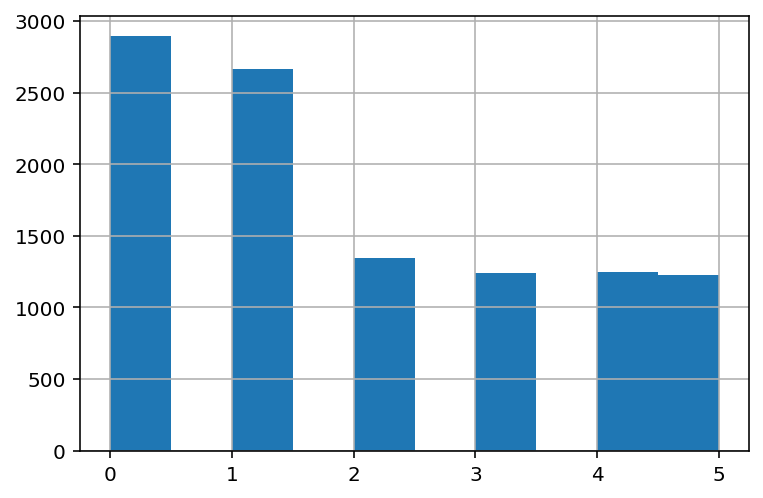

In [10]:
_ = TRAIN_DF[CFG.target_col].hist()

### Define Global Variables

In [11]:
if CFG.debug:
    EXP_NAME = "debug"
    writer = SummaryWriter(f"runs_v1/{EXP_NAME}")
    print(f"Start experiment: {EXP_NAME}")
else:
    if not CFG.resume:
        now = datetime.now()
        EXP_NAME = now.strftime("%d-%m-%Y-%H-%M")
        print(f"Start experiment: {EXP_NAME}")

        writer = SummaryWriter(f"runs_v1/{EXP_NAME}")
    else:
        # if resume should define from what to start
        PREV_NAME = CFG.prev_exp
        writer = SummaryWriter(f"runs_v1/{PREV_NAME}_{CFG.stage}")

Start experiment: 04-07-2020-20-48


In [12]:
# Set logger
logger = logging.getLogger()
logger.setLevel(logging.INFO)

log_format = logging.Formatter('%(message)s')
stream_handler = logging.StreamHandler()
stream_handler.setFormatter(log_format)
logger.handlers = [stream_handler]
# add logging handler to save training to the file
log_fname = f"{PROJ_PATH/'logs'}/{EXP_NAME}.log"
file_handler = logging.FileHandler(log_fname, mode="a")
file_handler.setFormatter(log_format)
logger.handlers.append(file_handler)

In [13]:
LOSSES = {
    "cce" : nn.CrossEntropyLoss(),
    "mse" : nn.MSELoss(),
    "ls_soft_ce" : LabelSmoothSoftmaxCEV1(),
    "ohem" : TopkCrossEntropy(),
    "bce" : TopkBCEWithLogitsLoss() if CFG.ohem else nn.BCEWithLogitsLoss(),
}

In [14]:
# key - string, value - tuple(sceduler, if it epoch type)
epoch_type = True
SCHEDULERS = {
    "reduce_on_plateau" : (ReduceLROnPlateau, epoch_type),
    "one_cycle": (OneCycleLR, not epoch_type),
    "cawr": (CosineAnnealingWarmUpRestarts, not epoch_type),
    "none": (None, None)
}

In [15]:
# schedulers
def get_scheduler(optimizer,train_dataloader, schedule_type=CFG.schedule_type, resume=False):
    assert schedule_type in SCHEDULERS, f"{schedule_type} not in SCHEDULERS"
    if schedule_type == "reduce_on_plateau":
        return (SCHEDULERS[schedule_type][0](optimizer, 'min', factor=0.5, patience=CFG.rlopp if not resume else CFG.rlopp + 2, verbose=True), 
                SCHEDULERS[schedule_type][1])
    elif schedule_type == "one_cycle":
        return (SCHEDULERS[schedule_type][0](optimizer, max_lr=[CFG.lr, CFG.lr*10] if CFG.finetune == "1stage" else CFG.lr,
                                             steps_per_epoch=int(len(train_dataloader) / CFG.accum_step), epochs=CFG.epoch, pct_start=1/CFG.epoch, 
                                             cycle_momentum=False, final_div_factor=CFG.oc_final_div_factor),
                SCHEDULERS[schedule_type][1])
    elif schedule_type == "cawr":
        return (SCHEDULERS[schedule_type][0](optimizer, T_0=CFG.cawr_T_0, T_mult=CFG.cawr_T_mult, eta_max=CFG.lr, T_up=CFG.cawr_T_up, gamma=CFG.cawr_gamma),
                SCHEDULERS[schedule_type][1])
    else:
        return (SCHEDULERS[schedule_type][0],
                SCHEDULERS[schedule_type][1])

### Train Eval Loop

In [16]:
# Train Eval Loop
def train_eval_loop(
    train_dataloader,
    val_dataloader,
    model,
    optimizer,
    criterion,
    accum_step=CFG.accum_step,
    checkpoint=False,
    num_epochs=CFG.epoch,
    device=device,
    tb_tag="",
    model_name="debug",
):
    """Split it into the set of inner functions to siplify the loop itself"""
    # Inner Functions
    # write to TensorBoard helpers
    def weights_to_tb(step=0):
        conv1_weight = list(model.parameters())[0].data.to("cpu")
        img_grid = torchvision.utils.make_grid(conv1_weight.float(), normalize=True)
        writer.add_image(
            tag=f"Model conv1 weights {tb_tag}", img_tensor=img_grid, global_step=step
        )

    def input_img_to_tb(inputs, step):
        img = reverse_show_img(inputs[0], denorm=True)
        writer.add_image(
            tag=f"Input Image {tb_tag}",
            img_tensor=img,
            global_step=step,
            dataformats="HWC",
        )
        del img

    def preds_to_tb(outputs, inputs, labels, step):
        figure = plot_classes_preds(
            outputs.to("cpu"), inputs.to("cpu"), labels.to("cpu")
        )
        writer.add_figure(
            tag=f"Actuals vs Predictions {tb_tag}", figure=figure, global_step=step
        )

    def text_preds_to_tb(outputs, labels, step):
        preds, targs = compute_preds(outputs, labels)
        preds_text = f"targs: {targs}, preds: {preds}"
        writer.add_text(
            f"Actuals vs Predictions {tb_tag}", preds_text, global_step=step
        )

    def metrics_to_tb(mode, train_loss, train_score, val_loss, val_score, step):
        writer.add_text(
            f"On best {mode} save:",
            f"tr_loss: {train_loss:.4f}, tr_qwk: {train_score:.4f}, val_loss: {val_loss:.4f}, val_qwk: {val_score:.4f}",  # noqa
            global_step=step,
        )

    def conf_matrix_to_tb(val_epoch_labels, val_epoch_preds, step):
        writer.add_figure(
            tag=f"Confusion matrix {tb_tag}",
            figure=plot_confusion_matrix(
                val_epoch_labels, val_epoch_preds, normalize=True
            ),
            global_step=step,
        )
        
    def attention_to_tb(att, step):
        att_arr = att.data.cpu().numpy()[0, 0]
        text = f"{np.around(att_arr, decimals=3)}"
        writer.add_text(f"Attention Map for Oth Val sample {tb_tag}", text, global_step=step)
        
        
    def compute_preds(outputs, labels, loss_type=CFG.loss):
        if loss_type == "bce":
            preds = outputs.detach().sigmoid().sum(1).round()
            targs = labels.sum(1)
        elif loss_type == "mse":
            preds = outputs.detach().round()
            targs = labels
        else:
            preds = outputs.detach().argmax(1)
            targs = labels
        return preds.int(), targs.int()
        

    # Train/Eval Loop
    # write first layer weights to TB @ init phase
    if not CFG.debug:
        weights_to_tb()

    # prepare model and optimizer
    model.to(device)
    if CFG.use_amp:  # automatic mixed precision
        model, optimizer = amp.initialize(model, optimizer, opt_level="O2")
        
    # init scheduler after amp init of optimizer
    scheduler, sch_is_epoch_type = get_scheduler(optimizer, train_dataloader, resume=CFG.resume)
    
    # define epochs numbers to look into input images and predictions,
    # no more than 30 times per full training
    vis_step = np.ceil(num_epochs / 30).astype(int)
    visual_epochs = list(range(0, num_epochs, vis_step))
    # metrics to wathch for model checkpointing
    best_qwk = -100 if not checkpoint else checkpoint["best_qwk"]
    best_val_loss = np.inf if not checkpoint else checkpoint["best_val_loss"]

    start_epoch = 0 if not checkpoint else checkpoint["epoch"] + 1
    for epoch in range(start_epoch, num_epochs):
        logging.info(f"Epoch {epoch}/{num_epochs - 1}")
        logging.info("=" * 10)

        # Training Phase
        # Set training mode
        model.train()
        train_running_loss = 0.0
        accum_train_loss = 0.0
        train_epoch_preds, train_epoch_labels = [], []

        # We accumulate, zero at training epoch begins
        optimizer.zero_grad()

        # Iterate over train data.
        tk_train = tqdm(enumerate(train_dataloader), total=len(train_dataloader))
        for i, data in tk_train:
            # Calculate global step for TensorBoard
            train_global_step = epoch * len(train_dataloader) + i

            inputs, labels = data
            # Visualize input before model at the middle of epoch:
            if epoch in visual_epochs and i == len(train_dataloader) // 2:
                input_img_to_tb(inputs, train_global_step)

            inputs = inputs.to(device)
            labels = labels.to(device)

            if CFG.att:
                outputs, _ = model(inputs) # don't need att map here
            else:
                outputs = model(inputs)
            
            # then usimg accumulated gradients they sum up every loss.backward, we want mean of gradients
            # and so pararameter updates will be the same in case of accum_step > 1
            loss = criterion(outputs, labels) / accum_step
            if CFG.use_amp:
                with amp.scale_loss(loss, optimizer) as scaled_loss:
                    scaled_loss.backward()
            else:
                loss.backward()
            
            accum_train_loss += loss.item()
            # we accumulate gradients and make optimization step once per
            # # of accum_step
            if (i + 1) % accum_step == 0:
                optimizer.step()
                optimizer.zero_grad()
                # Add Batch Type Scheduler step here (update lr only after optimizer step):
                if scheduler and not sch_is_epoch_type:
                    if CFG.schedule_type == "cawr":
                        scheduler.step(epoch + i / len(train_dataloader))
                    else:
                        scheduler.step()

                # loss is mean across batch, divide by number of steps in epoch
                # (so loss is normalized) + we only update train_running_loss every accum_step
                train_running_loss += accum_train_loss / (len(train_dataloader) / accum_step)
                # tensorboarding loss
                writer.add_scalar(
                    tag=f"Training loss {tb_tag}",
                    scalar_value=accum_train_loss,
                    global_step=train_global_step,
                )
                # zero accum_train_loss 
                accum_train_loss = 0.

            # collect train preds and labels for QWK
            preds, targs = compute_preds(outputs, labels)
            train_epoch_preds.append(preds)
            train_epoch_labels.append(targs)
            
        # Validation Phase
        # Set evaluation mode
        model.eval()
        val_running_loss = 0.0
        val_epoch_preds, val_epoch_labels = [], []
        # Iterate over val data
        tk_val = tqdm(enumerate(val_dataloader), total=len(val_dataloader))
        for j, data in tk_val:
            # Calculate global step
            val_global_step = epoch * len(val_dataloader) + j
            inputs, labels = data
            if CFG.aux_tile:
                inp_main, inp_aux = inputs
                inp_main, inp_aux = inp_main.to(device), inp_aux.to(device)
            else:
                inputs = inputs.to(device)
            
            labels = labels.to(device)
            with torch.no_grad():
                if CFG.aux_tile:
                    out_main = model(inp_main)
                    out_aux = model(inp_aux)
                    outputs = (out_main + out_aux) / 2
                else:
                    if CFG.att:
                        outputs, att = model(inputs)
                    else:
                        outputs = model(inputs)
            if CFG.ohem:
                loss = criterion(outputs, labels, valid=True)
            else:
                loss = criterion(outputs, labels)
            
            val_running_loss += loss.item() / len(val_dataloader)
            # tensorboarding loss
            writer.add_scalar(
                tag=f"Validation loss {tb_tag}",
                scalar_value=loss.item(),
                global_step=val_global_step,
            )

            # collect validation preds and labels for QWK
            preds, targs = compute_preds(outputs, labels)
            val_epoch_preds.append(preds)
            val_epoch_labels.append(targs)

            # visualise predictions for 0th validation batch
            if epoch in visual_epochs and j == 0:
                text_preds_to_tb(outputs, labels, val_global_step)
                
                # look into attention map if use it
                if CFG.att:
                    attention_to_tb(att, val_global_step)

        # Epoch type Schedulers
        if scheduler and sch_is_epoch_type:
            scheduler.step(val_running_loss)
        # Write lr to TBD
        if CFG.finetune == "1stage":
            writer.add_scalar(
                tag=f"lr Interim {tb_tag}:",
                scalar_value=optimizer.param_groups[0]["lr"],
                global_step=train_global_step,
            )
            writer.add_scalar(
                tag=f"lr Classifier {tb_tag}:",
                scalar_value=optimizer.param_groups[1]["lr"],
                global_step=train_global_step,
            )

        else:
            writer.add_scalar(
                tag=f"lr {tb_tag}:",
                scalar_value=optimizer.param_groups[0]["lr"],
                global_step=train_global_step,
            )

        # "End of Epoch" Phase
        logging.info(
            f"Training Loss: {train_running_loss:.4f}\tValidation Loss: {val_running_loss:.4f}"  # noqa
        )

        # Calculate epoch predictions distribution
        train_epoch_preds = torch.cat(train_epoch_preds).cpu().numpy()
        train_epoch_labels = torch.cat(train_epoch_labels).cpu().numpy()
        val_epoch_preds = torch.cat(val_epoch_preds).cpu().numpy()
        val_epoch_labels = torch.cat(val_epoch_labels).cpu().numpy()
        logging.info(
            f"Counter train preds: {Counter(train_epoch_preds)}\tCounter val preds: {Counter(val_epoch_preds)}"  # noqa
        )
        # Calculate epoch QWK
        train_qwk = cohen_kappa_score(
            train_epoch_preds, train_epoch_labels, weights="quadratic"
        )
        val_qwk = cohen_kappa_score(
            val_epoch_preds, val_epoch_labels, weights="quadratic"
        )
        logging.info(f"Epoch train QWK: {train_qwk:.3f}\tval QWK: {val_qwk:.3f}")
        writer.add_scalar(
            tag=f"Training QWK {tb_tag}", scalar_value=train_qwk, global_step=epoch
        )
        writer.add_scalar(
            tag=f"Validation QWK {tb_tag}", scalar_value=val_qwk, global_step=epoch
        )

        # On the best val loss do:
        if val_running_loss < best_val_loss:
            # update best and save model
            best_val_loss = val_running_loss
            logging.info(f"  Epoch {epoch} - Save Best Loss: {best_val_loss:.4f} Model")
            torch.save(
                {
                    "epoch": epoch,
                    "model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    "best_val_loss": best_val_loss,
                    "best_qwk": val_qwk,
                },
                f"{MODEL_PATH}/{model_name}_{epoch}_loss.pth",
            )
            # add losses as text to TB
            metrics_to_tb(
                "loss",
                train_running_loss,
                train_qwk,
                val_running_loss,
                val_qwk,
                val_global_step,
            )
            # add image of conv1 weights to TB
            if not CFG.debug:
                weights_to_tb(val_global_step)
            # add confusion matrix to TB
            conf_matrix_to_tb(val_epoch_labels, val_epoch_preds, val_global_step)
            
        # On the best val loss do:
        if val_qwk > best_qwk:
            # update best and save model
            best_qwk = val_qwk
            logging.info(f"  Epoch {epoch} - Save Best QWK: {best_qwk:.4f} Model")
            torch.save(
                {
                    "epoch": epoch,
                    "model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    "best_val_loss": val_running_loss,
                    "best_qwk": best_qwk,
                },
                f"{MODEL_PATH}/{model_name}_{epoch}_qwk.pth",
            )
            # add losses as text to TB
            metrics_to_tb(
                "qwk",
                train_running_loss,
                train_qwk,
                val_running_loss,
                val_qwk,
                val_global_step,
            )
            # add image of conv1 weights to TB
            if not CFG.debug:
                weights_to_tb(val_global_step)
            # add confusion matrix to TB
            conf_matrix_to_tb(val_epoch_labels, val_epoch_preds, val_global_step)
        
        # maybe it helps!
#         torch.cuda.empty_cache()

    # End of loop
    return model, best_val_loss, best_qwk

### Prepare CV - strategy

In [17]:
CFG.debug = True

In [17]:
# That for the first time

In [28]:
if CFG.debug:
    folds_fn = "folds_db.csv"
    try: 
        folds = pd.read_csv(PANDA_PATH/folds_fn)
    except FileNotFoundError:
        folds = TRAIN_DF.sample(n=500, random_state=CFG.seed).reset_index(drop=True).copy()
else:
    folds_fn = "folds.csv"
    try:
        folds = pd.read_csv(PANDA_PATH/folds_fn)
    except FileNotFoundError:
        folds = TRAIN_DF.copy()

In [16]:
if not (PANDA_PATH/folds_fn).exists():
    train_labels = folds[CFG.target_col].values
    kf = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
    for fold, (train_index, val_index) in enumerate(kf.split(folds.values, train_labels)):
        folds.loc[val_index, 'fold'] = int(fold)
    folds['fold'] = folds['fold'].astype(int)
    folds.to_csv(PANDA_PATH/folds_fn, index=None)
    folds.head()

NameError: name 'folds_fn' is not defined

In [17]:
# Here use existing (folds_dedup is folds_cleaned + dropped duplicates)
# See corresponding notebooks: Suspicious_Input for cleaning
# and Find_Drop_Duplicates for duplicates

In [17]:
if CFG.debug:
    folds = pd.read_csv(PANDA_PATH/"folds_db.csv")
else:
    folds = pd.read_csv(PANDA_PATH/"folds_dedup_v1.csv")

In [18]:
folds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9983 entries, 0 to 9982
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   image_id       9983 non-null   object 
 1   data_provider  9983 non-null   object 
 2   isup_grade     9983 non-null   int64  
 3   gleason_score  9983 non-null   object 
 4   fold           9983 non-null   int64  
 5   class_weight   9983 non-null   float64
dtypes: float64(1), int64(2), object(3)
memory usage: 468.1+ KB


In [19]:
# folds = folds.sample(20)

### Init Data

In [20]:
# get folds (all experiments validated on fold 0)
train_df = folds[folds["fold"] != 0].copy()
val_df = folds[folds["fold"] == 0].copy()

# define datasets
if CFG.dataset == "lazy":
    train_ds = LazyTilesDataset(train_df, transform=get_transforms(data="train", aug=CFG.aug_type), debug=False)
    val_ds = TilesTrainDataset(val_df, is_train=False, transform=get_transforms(data="valid"), debug=False) # same allways to compare with previous results
elif CFG.dataset == "tiles":
    train_ds = TilesTrainDataset(train_df, transform=get_transforms(data="train", aug=CFG.aug_type), debug=False, aux_tile=CFG.aux_tile, regression=CFG.regression, loss=CFG.loss)
    val_ds = TilesTrainDataset(val_df, is_train=False, transform=get_transforms(data="valid"), debug=False, aux_tile=CFG.aux_tile, regression=CFG.regression, loss=CFG.loss)
elif CFG.dataset == "patch":
    train_ds = PatchTrainDataset(train_df, transform=get_transforms(data="train", aug=CFG.aug_type), debug=False)
    val_ds = PatchTrainDataset(val_df, is_train=False, debug=False)
elif CFG.dataset == "hdf5":
    train_ds = H5PatchDataset(file_path=PANDA_PATH / "hdf5", fnames=["patch256x16x1_fold_1.h5", "patch256x16x1_fold_2.h5", "patch256x16x1_fold_3.h5"])
    val_ds = H5PatchDataset(file_path=PANDA_PATH / "hdf5", fnames=["patch256x16x1_fold_0.h5"])
else:
    print(f"No such dataset {CFG.dataset}")
    
# define a data loader
if CFG.dataset == "hdf5":
    # use specific sampler (so not to load hdf5 files to memory too frequently)
    sampler = SeqenceRandomSampler(len(train_ds), train_ds._common_len)
    train_dataloader = DataLoader(train_ds, batch_size=CFG.batch_size, sampler=sampler, num_workers=min(CFG.batch_size, 8), pin_memory=True)
    val_dataloader = DataLoader(val_ds, batch_size=CFG.batch_size, shuffle=False, num_workers=min(CFG.batch_size, 8), pin_memory=True)
else:
    train_dataloader = DataLoader(train_ds, batch_size=CFG.batch_size, shuffle=True, num_workers=min(CFG.batch_size+2, 6), pin_memory=True)
    val_dataloader = DataLoader(val_ds, batch_size=CFG.batch_size, shuffle=False, num_workers=min(CFG.batch_size+2, 6), pin_memory=False)

### Init Functions

In [21]:
def init_model(train_df=train_df, arch=CFG.arch, pre_init_fc_bias=CFG.pre_init_fc_bias, pretrained=True):
    # For now only torchvision models ok for attention
    if CFG.att:
        assert arch in ["resnet50", "resnet34"]
    
    # MIL variant
    if CFG.dataset == "patch":
        if arch == "efnet":
            model_ft = PatchEnetModel(backbone=CFG.enet_bone, pretrained=pretrained)
        elif arch == "bitM":
            model_ft = PatchBiTModel(pretrained=pretrained)
        else:
            if CFG.att:
                model_ft = AttentionModel(arch=arch, pretrained=pretrained)
            else:
                model_ft = PatchModel(arch=arch, pretrained=pretrained)
            if pre_init_fc_bias:
                if CFG.loss in ["cce", "ls_soft_ce", "ohem"]:
                    # initialize bias in the model
                    cls_probas = (train_df[CFG.target_col].value_counts() / len(train_df)).values
                    model_ft = init_last_layer_bias(model_ft, cls_probas)
    # Stitched Tiles variant
    elif CFG.dataset == "tiles":
        if arch in ["resnet50", "resnet34"]:
            model_ft = TilesModel(arch=arch, pretrained=pretrained, loss=CFG.loss, regression=CFG.regression)
        else:
            print(f"Tiles model for {arch} is not yet implemented!")
    
    return model_ft


def init_optimizer(model_ft):
    if CFG.finetune == "1stage":
        freeze_botom(model_ft)
        interm_params = [
            p[1]
            for p in model_ft.named_parameters()
            if (not p[0].startswith("fc") and p[1].requires_grad)
        ]
        if CFG.optim == "adam":
            optimizer = torch.optim.Adam(
                [
                    {"params": interm_params, "lr": CFG.lr},
                    {"params": model_ft.fc.parameters(), "lr": CFG.lr * 10},
                ]
            )
        elif CFG.optim == "sgd":
            optimizer = torch.optim.SGD(
                [
                    {"params": interm_params, "lr": CFG.lr},
                    {"params": model_ft.fc.parameters(), "lr": CFG.lr * 10},
                ],
                momentum=0.9,
                nesterov=True,
            )
    else:
        LR = CFG.lr / 1000 if CFG.schedule_type == "cawr" else CFG.lr
        if CFG.optim == "adam":
            optimizer = torch.optim.Adam(
                model_ft.parameters(), lr=LR, amsgrad=False
            )
        elif CFG.optim == "adamw":
            optimizer = torch.optim.AdamW(model_ft.parameters(), lr=LR, 
                                          weight_decay=CFG.wd)
        elif CFG.optim == "sgd":
            optimizer = torch.optim.SGD(
                model_ft.parameters(), lr=LR, momentum=0.9, nesterov=True
            )
        elif CFG.optim == "radam":
            optimizer = RAdam(model_ft.parameters(), lr=LR)

    return optimizer

criterion = LOSSES[CFG.loss]

### Debug Runs

In [23]:
print(" ".join([f"{key}: {val}" for key, val in CFG.__dict__.items() if not key.startswith("__")]))

debug: True seed: 1982 img_height: 224 img_width: 224 target_size: 6 img_id_col: image_id target_col: isup_grade tiff_layer: 1 stoch_sample: True num_tiles: 36 tile_sz: 224 batch_size: 8 accum_step: 1 dataset: tiles aux_tile: False aux_tile_sz: 0 aux_tile_num: 0 aug_type: light regression: True att: False arch: resnet34 enet_bone: efficientnet-b0 finetune: False model_cls: deep pre_init_fc_bias: False ohem: False loss: mse optim: adamw lr: 3e-05 wd: 0.0 schedule_type: none oc_final_div_factor: 10.0 cawr_T_0: 10 cawr_T_mult: 2 cawr_T_up: 3 cawr_gamma: 0.8 rlopp: 1 resume: False prev_exp: None from_epoch: 0 stage: 0 epoch: 45 n_fold: 4 use_amp: True descript: bce-ohem + rn34 + 224x36 tiles + OC + weighted data


In [24]:
logging.info(f'Start: {datetime.now().strftime("%d-%m-%Y-%H-%M")}')
model_ft = init_model()
optimizer = init_optimizer(model_ft)
    
scheduler, sch_is_epoch_type = get_scheduler(optimizer, train_dataloader)

_ = train_eval_loop(train_dataloader, val_dataloader, model_ft, optimizer, criterion, num_epochs=35)
logging.info(f'Finish: {datetime.now().strftime("%d-%m-%Y-%H-%M")}')

Start: 04-07-2020-20-35
Epoch 0/34


Selected optimization level O2:  FP16 training with FP32 batchnorm and FP32 master weights.

Defaults for this optimization level are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic


 50%|█████     | 1/2 [00:01<00:01,  1.94s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0


100%|██████████| 2/2 [00:03<00:00,  1.65s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0



100%|██████████| 1/1 [00:00<00:00,  2.04it/s]
Training Loss: 3.5146	Validation Loss: 2.1982
Counter train preds: Counter({3: 10, 2: 6})	Counter val preds: Counter({2: 3, 1: 1})
Epoch train QWK: -0.021	val QWK: 0.385
  Epoch 0 - Save Best Loss: 2.1982 Model
/home/ademyanchuk/Projects/ChestXRay/chestxray/visualize.py:155: RuntimeWarning: invalid value encountered in true_divide
  cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
  Epoch 0 - Save Best QWK: 0.3846 Model


Normalized confusion matrix
[[ 0.  1.  0.  0.]
 [ 0.  0.  1.  0.]
 [nan nan nan nan]
 [ 0.  0.  1.  0.]]


Epoch 1/34


Normalized confusion matrix
[[ 0.  1.  0.  0.]
 [ 0.  0.  1.  0.]
 [nan nan nan nan]
 [ 0.  0.  1.  0.]]


100%|██████████| 1/1 [00:00<00:00,  2.01it/s]
Training Loss: 3.4604	Validation Loss: 2.1138
Counter train preds: Counter({3: 11, 2: 5})	Counter val preds: Counter({2: 3, 1: 1})
Epoch train QWK: 0.076	val QWK: 0.385
  Epoch 1 - Save Best Loss: 2.1138 Model
Epoch 2/34


Normalized confusion matrix
[[ 0.  1.  0.  0.]
 [ 0.  0.  1.  0.]
 [nan nan nan nan]
 [ 0.  0.  1.  0.]]


100%|██████████| 1/1 [00:00<00:00,  1.91it/s]
Training Loss: 3.0892	Validation Loss: 2.0689
Counter train preds: Counter({3: 10, 2: 6})	Counter val preds: Counter({2: 2, 3: 1, 1: 1})
Epoch train QWK: 0.113	val QWK: 0.167
  Epoch 2 - Save Best Loss: 2.0689 Model
Epoch 3/34


Normalized confusion matrix
[[0.  1.  0.  0.  0. ]
 [0.  0.  0.5 0.5 0. ]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [0.  0.  1.  0.  0. ]]


100%|██████████| 1/1 [00:00<00:00,  1.68it/s]
Training Loss: 2.9369	Validation Loss: 2.0173
Counter train preds: Counter({3: 10, 2: 6})	Counter val preds: Counter({2: 2, 3: 1, 1: 1})
Epoch train QWK: 0.314	val QWK: 0.167
  Epoch 3 - Save Best Loss: 2.0173 Model
Epoch 4/34


Normalized confusion matrix
[[0.  1.  0.  0.  0. ]
 [0.  0.  0.5 0.5 0. ]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [0.  0.  1.  0.  0. ]]


100%|██████████| 1/1 [00:00<00:00,  2.01it/s]
Training Loss: 2.3764	Validation Loss: 1.9679
Counter train preds: Counter({2: 9, 3: 7})	Counter val preds: Counter({2: 2, 3: 1, 1: 1})
Epoch train QWK: 0.405	val QWK: 0.167
  Epoch 4 - Save Best Loss: 1.9679 Model
Epoch 5/34


Normalized confusion matrix
[[0.  1.  0.  0.  0. ]
 [0.  0.  0.5 0.5 0. ]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [0.  0.  1.  0.  0. ]]


100%|██████████| 1/1 [00:00<00:00,  1.99it/s]
Training Loss: 2.0838	Validation Loss: 1.7719
Counter train preds: Counter({3: 9, 2: 5, 1: 2})	Counter val preds: Counter({2: 3, 1: 1})
Epoch train QWK: 0.411	val QWK: 0.385
  Epoch 5 - Save Best Loss: 1.7719 Model
Epoch 6/34


Normalized confusion matrix
[[ 0.  1.  0.  0.]
 [ 0.  0.  1.  0.]
 [nan nan nan nan]
 [ 0.  0.  1.  0.]]


100%|██████████| 1/1 [00:00<00:00,  2.01it/s]
Training Loss: 2.2472	Validation Loss: 1.6648
Counter train preds: Counter({3: 9, 2: 5, 1: 1, 4: 1})	Counter val preds: Counter({2: 3, 1: 1})
Epoch train QWK: 0.420	val QWK: 0.385
  Epoch 6 - Save Best Loss: 1.6648 Model
Epoch 7/34


Normalized confusion matrix
[[ 0.  1.  0.  0.]
 [ 0.  0.  1.  0.]
 [nan nan nan nan]
 [ 0.  0.  1.  0.]]


100%|██████████| 1/1 [00:00<00:00,  2.04it/s]
Training Loss: 1.6982	Validation Loss: 1.6867
Counter train preds: Counter({2: 7, 3: 5, 4: 3, 1: 1})	Counter val preds: Counter({2: 3, 1: 1})
Epoch train QWK: 0.601	val QWK: 0.385
Epoch 8/34
100%|██████████| 1/1 [00:00<00:00,  1.99it/s]
Training Loss: 1.6647	Validation Loss: 1.7778
Counter train preds: Counter({2: 7, 3: 6, 4: 2, 1: 1})	Counter val preds: Counter({2: 2, 3: 1, 1: 1})
Epoch train QWK: 0.568	val QWK: 0.667
  Epoch 8 - Save Best QWK: 0.6667 Model
Epoch 9/34


Normalized confusion matrix
[[ 0.  1.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [ 0.  0.  0.  1.  0.]]


100%|██████████| 1/1 [00:00<00:00,  2.04it/s]
Training Loss: 1.3790	Validation Loss: 1.7448
Counter train preds: Counter({2: 5, 3: 5, 4: 3, 1: 3})	Counter val preds: Counter({3: 2, 2: 1, 1: 1})
Epoch train QWK: 0.643	val QWK: 0.500
Epoch 10/34
100%|██████████| 1/1 [00:00<00:00,  1.86it/s]
Training Loss: 1.2459	Validation Loss: 1.7717
Counter train preds: Counter({2: 6, 4: 5, 1: 3, 3: 2})	Counter val preds: Counter({3: 2, 2: 1, 1: 1})
Epoch train QWK: 0.760	val QWK: 0.500
Epoch 11/34
100%|██████████| 1/1 [00:00<00:00,  2.05it/s]
Training Loss: 1.1314	Validation Loss: 1.8888
Counter train preds: Counter({2: 8, 4: 3, 3: 3, 5: 1, 0: 1})	Counter val preds: Counter({3: 2, 2: 1, 1: 1})
Epoch train QWK: 0.730	val QWK: 0.500
Epoch 12/34
100%|██████████| 1/1 [00:00<00:00,  1.99it/s]
Training Loss: 0.9647	Validation Loss: 1.9763
Counter train preds: Counter({2: 6, 4: 5, 1: 3, 3: 2})	Counter val preds: Counter({3: 2, 2: 1, 1: 1})
Epoch train QWK: 0.786	val QWK: 0.500
Epoch 13/34
100%|██████████| 1

### Experiment Run

#### Learning Rate Finder

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic



Learning rate search finished. See the graph with {finder_name}.plot()


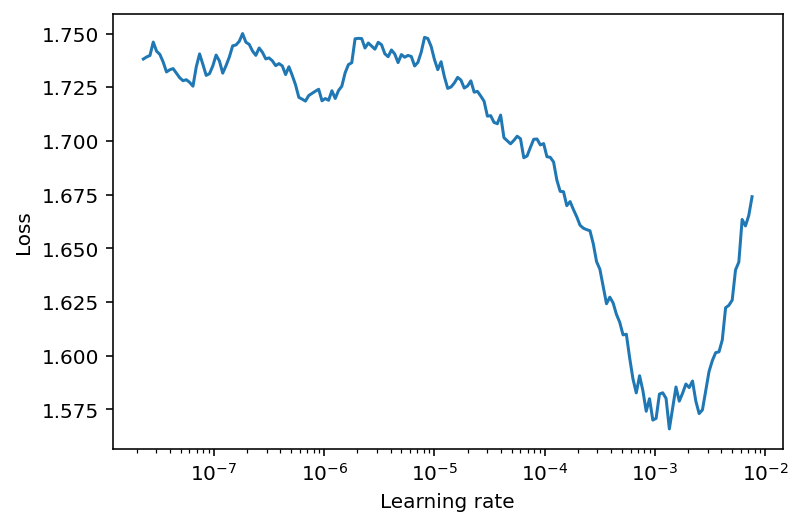

In [17]:
# get folds
train_df = folds[folds["fold"] != 0].copy()
# define datasets
if CFG.dataset == "lazy":
    train_ds = LazyTilesDataset(train_df, transform=get_transforms(data="train", aug=CFG.aug_type), debug=False)
elif CFG.dataset == "tiles":
    train_ds = TilesTrainDataset(train_df, is_train=CFG.stoch_sample, transform=get_transforms(data="train", aug=CFG.aug_type), debug=False)
elif CFG.dataset == "patch":
    train_ds = PatchTrainDataset(train_df, transform=get_transforms(data="train", aug=CFG.aug_type), debug=False)
    
# define a data loader
train_dataloader = DataLoader(train_ds, batch_size=CFG.batch_size, shuffle=True, num_workers=min(CFG.batch_size, 10), pin_memory=True)

model_ft = Model(arch="resnet34")
# initialize bias in the model
cls_probas = (train_df[CFG.target_col].value_counts() / len(train_df)).values
model_ft = init_last_layer_bias(model_ft, cls_probas)
model_ft.to(device)

criterion = LOSSES[CFG.loss]


if CFG.finetune == "1stage":
    freeze_botom(model_ft)
    interm_params = [p[1] for p in model_ft.named_parameters() if (not p[0].startswith('fc') and p[1].requires_grad)]
    if CFG.optim == "adam":
        optimizer = torch.optim.Adam([
                    {'params': interm_params, 'lr': CFG.lr},
                    {'params': model_ft.fc.parameters(), 'lr': CFG.lr*10}
                ])
    elif CFG.optim == "sgd":
        optimizer = torch.optim.SGD([
                    {'params': interm_params, 'lr': CFG.lr},
                    {'params': model_ft.fc.parameters(), 'lr': CFG.lr*10}
            ], momentum=0.9, nesterov=True)
else:
    if CFG.optim == "adam":
        optimizer = torch.optim.Adam(model_ft.parameters(), lr=CFG.lr * 1e-4, amsgrad=False)
    elif CFG.optim == "sgd":
        optimizer = torch.optim.SGD(model_ft.parameters(), lr=CFG.lr * 1e-4, momentum=0.9, nesterov=True)
    elif CFG.optim == "radam":
        optimizer = RAdam(model_ft.parameters(), lr=CFG.lr * 1e-4)
    
if CFG.use_amp:
    model_ft, optimizer = amp.initialize(model_ft, optimizer, opt_level='O1')
    
lr_finder = LRFinder(model_ft, optimizer, criterion, device=device)
lr_finder.range_test(train_dataloader, end_lr=1e-2, num_iter=200, step_mode="exp", accumulation_steps=CFG.accum_step)
lr_finder.plot()
lr_finder.reset()

#### Experiment

In [22]:
print(" ".join([f"{key}: {val}\n" for key, val in CFG.__dict__.items() if not key.startswith("__")]))

debug: False
 seed: 1982
 img_height: 224
 img_width: 224
 target_size: 6
 img_id_col: image_id
 target_col: isup_grade
 tiff_layer: 1
 stoch_sample: True
 num_tiles: 36
 tile_sz: 224
 batch_size: 8
 accum_step: 1
 dataset: tiles
 aux_tile: False
 aux_tile_sz: 0
 aux_tile_num: 0
 aug_type: light
 regression: True
 att: False
 arch: resnet34
 enet_bone: efficientnet-b0
 finetune: False
 model_cls: deep
 pre_init_fc_bias: False
 ohem: False
 loss: mse
 optim: adamw
 lr: 0.0003
 wd: 0.0
 schedule_type: one_cycle
 oc_final_div_factor: 10.0
 cawr_T_0: 10
 cawr_T_mult: 2
 cawr_T_up: 3
 cawr_gamma: 0.8
 rlopp: 1
 resume: False
 prev_exp: None
 from_epoch: 0
 stage: 0
 epoch: 50
 n_fold: 4
 use_amp: True
 descript: mse + rn34 + 224x36 tiles + OC



In [23]:
writer.add_text("Experiment Description:", CFG.descript)

In [24]:
model_ft = init_model()
optimizer = init_optimizer(model_ft)

In [25]:
logging.info(f'Start: {datetime.now().strftime("%d-%m-%Y-%H-%M")}')
# Start Train/Eval Experiment
model_ft, best_loss, best_qwk = train_eval_loop(train_dataloader, val_dataloader, model_ft, optimizer, criterion, model_name=EXP_NAME)
logging.info(f'Finish: {datetime.now().strftime("%d-%m-%Y-%H-%M")}')

Start: 04-07-2020-20-48
Epoch 0/49


Selected optimization level O2:  FP16 training with FP32 batchnorm and FP32 master weights.

Defaults for this optimization level are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic


  0%|          | 0/936 [00:00<?, ?it/s]/home/ademyanchuk/.cache/pypoetry/virtualenvs/chestxray-uNc73CMC-py3.7/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
  0%|          | 1/936 [00:04<1:05:33,  4.21s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0


  0%|          | 2/936 [00:04<48:45,  3.13s/it]  

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0


  3%|▎         | 27/936 [00:18<08:30,  1.78it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0


100%|██████████| 313/313 [02:21<00:00,  2.21it/s]
Training Loss: 1.8908	Validation Loss: 2.1417
Counter train preds: Counter({1: 2252, 2: 2077, 3: 1698, 4: 782, 0: 642, 5: 31})	Counter val preds: Counter({0: 1371, 1: 466, 4: 245, 3: 215, 2: 195, 5: 9})
Epoch train QWK: 0.532	val QWK: 0.579
  Epoch 0 - Save Best Loss: 2.1417 Model
  Epoch 0 - Save Best QWK: 0.5792 Model


Normalized confusion matrix
[[0.89044944 0.08146067 0.01404494 0.00842697 0.00561798 0.        ]
 [0.76107595 0.19303797 0.03006329 0.01265823 0.00316456 0.        ]
 [0.42993631 0.29617834 0.14968153 0.09235669 0.03184713 0.        ]
 [0.18466899 0.24390244 0.14634146 0.2543554  0.17073171 0.        ]
 [0.16083916 0.27622378 0.2027972  0.15734266 0.1958042  0.00699301]
 [0.08148148 0.16296296 0.07037037 0.2        0.45925926 0.02592593]]


Epoch 1/49


Normalized confusion matrix
[[0.89044944 0.08146067 0.01404494 0.00842697 0.00561798 0.        ]
 [0.76107595 0.19303797 0.03006329 0.01265823 0.00316456 0.        ]
 [0.42993631 0.29617834 0.14968153 0.09235669 0.03184713 0.        ]
 [0.18466899 0.24390244 0.14634146 0.2543554  0.17073171 0.        ]
 [0.16083916 0.27622378 0.2027972  0.15734266 0.1958042  0.00699301]
 [0.08148148 0.16296296 0.07037037 0.2        0.45925926 0.02592593]]


100%|██████████| 313/313 [02:21<00:00,  2.21it/s]
Training Loss: 1.5746	Validation Loss: 1.6800
Counter train preds: Counter({1: 2278, 2: 1650, 3: 1393, 0: 1185, 4: 950, 5: 26})	Counter val preds: Counter({2: 588, 3: 542, 0: 511, 1: 434, 4: 425, 5: 1})
Epoch train QWK: 0.632	val QWK: 0.629
  Epoch 1 - Save Best Loss: 1.6800 Model
  Epoch 1 - Save Best QWK: 0.6287 Model


Normalized confusion matrix
[[0.4761236  0.19662921 0.18539326 0.12640449 0.01544944 0.        ]
 [0.18829114 0.31170886 0.35917722 0.13132911 0.00949367 0.        ]
 [0.0955414  0.15605096 0.40764331 0.2866242  0.05414013 0.        ]
 [0.03484321 0.07317073 0.15679443 0.41463415 0.32055749 0.        ]
 [0.02097902 0.04545455 0.13636364 0.32167832 0.47202797 0.0034965 ]
 [0.02592593 0.05185185 0.06296296 0.25185185 0.60740741 0.        ]]


Epoch 2/49


Normalized confusion matrix
[[0.4761236  0.19662921 0.18539326 0.12640449 0.01544944 0.        ]
 [0.18829114 0.31170886 0.35917722 0.13132911 0.00949367 0.        ]
 [0.0955414  0.15605096 0.40764331 0.2866242  0.05414013 0.        ]
 [0.03484321 0.07317073 0.15679443 0.41463415 0.32055749 0.        ]
 [0.02097902 0.04545455 0.13636364 0.32167832 0.47202797 0.0034965 ]
 [0.02592593 0.05185185 0.06296296 0.25185185 0.60740741 0.        ]]


 17%|█▋        | 163/936 [01:28<06:40,  1.93it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0


100%|██████████| 936/936 [08:12<00:00,  1.90it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0



100%|██████████| 313/313 [02:21<00:00,  2.21it/s]
Training Loss: 1.4748	Validation Loss: 1.8332
Counter train preds: Counter({1: 2281, 2: 1593, 0: 1301, 3: 1209, 4: 1034, 5: 64})	Counter val preds: Counter({2: 1207, 3: 578, 1: 514, 4: 164, 0: 38})
Epoch train QWK: 0.668	val QWK: 0.482
Epoch 3/49
100%|██████████| 313/313 [02:22<00:00,  2.20it/s]
Training Loss: 1.4016	Validation Loss: 1.2343
Counter train preds: Counter({1: 2122, 2: 1633, 0: 1408, 3: 1206, 4: 1059, 5: 54})	Counter val preds: Counter({1: 784, 2: 661, 0: 465, 3: 316, 4: 253, 5: 22})
Epoch train QWK: 0.681	val QWK: 0.703
  Epoch 3 - Save Best Loss: 1.2343 Model
  Epoch 3 - Save Best QWK: 0.7033 Model


Normalized confusion matrix
[[0.51544944 0.36235955 0.0997191  0.01544944 0.00702247 0.        ]
 [0.11708861 0.5585443  0.31012658 0.01265823 0.00158228 0.        ]
 [0.03503185 0.32802548 0.53821656 0.09235669 0.00318471 0.00318471]
 [0.0174216  0.11149826 0.38675958 0.34843206 0.1358885  0.        ]
 [0.01748252 0.07342657 0.23426573 0.36013986 0.3006993  0.01398601]
 [0.01111111 0.06296296 0.17407407 0.24074074 0.44814815 0.06296296]]


Epoch 4/49


Normalized confusion matrix
[[0.51544944 0.36235955 0.0997191  0.01544944 0.00702247 0.        ]
 [0.11708861 0.5585443  0.31012658 0.01265823 0.00158228 0.        ]
 [0.03503185 0.32802548 0.53821656 0.09235669 0.00318471 0.00318471]
 [0.0174216  0.11149826 0.38675958 0.34843206 0.1358885  0.        ]
 [0.01748252 0.07342657 0.23426573 0.36013986 0.3006993  0.01398601]
 [0.01111111 0.06296296 0.17407407 0.24074074 0.44814815 0.06296296]]


100%|██████████| 313/313 [02:22<00:00,  2.20it/s]
Training Loss: 1.3298	Validation Loss: 1.1289
Counter train preds: Counter({1: 2022, 2: 1651, 0: 1535, 3: 1124, 4: 1050, 5: 100})	Counter val preds: Counter({0: 711, 1: 580, 2: 450, 4: 392, 3: 298, 5: 70})
Epoch train QWK: 0.701	val QWK: 0.768
  Epoch 4 - Save Best Loss: 1.1289 Model
  Epoch 4 - Save Best QWK: 0.7679 Model


Normalized confusion matrix
[[0.73033708 0.19101124 0.05196629 0.01544944 0.00983146 0.00140449]
 [0.23101266 0.46202532 0.26265823 0.03639241 0.00791139 0.        ]
 [0.06050955 0.25796178 0.41401274 0.21974522 0.0477707  0.        ]
 [0.04181185 0.1184669  0.21254355 0.29965157 0.31707317 0.01045296]
 [0.03846154 0.07342657 0.14335664 0.25874126 0.45104895 0.03496503]
 [0.01111111 0.05925926 0.05555556 0.12962963 0.53703704 0.20740741]]


Epoch 5/49


Normalized confusion matrix
[[0.73033708 0.19101124 0.05196629 0.01544944 0.00983146 0.00140449]
 [0.23101266 0.46202532 0.26265823 0.03639241 0.00791139 0.        ]
 [0.06050955 0.25796178 0.41401274 0.21974522 0.0477707  0.        ]
 [0.04181185 0.1184669  0.21254355 0.29965157 0.31707317 0.01045296]
 [0.03846154 0.07342657 0.14335664 0.25874126 0.45104895 0.03496503]
 [0.01111111 0.05925926 0.05555556 0.12962963 0.53703704 0.20740741]]


100%|██████████| 313/313 [02:21<00:00,  2.21it/s]
Training Loss: 1.2962	Validation Loss: 1.2287
Counter train preds: Counter({1: 2115, 2: 1560, 0: 1504, 3: 1131, 4: 1082, 5: 90})	Counter val preds: Counter({1: 944, 2: 583, 0: 363, 3: 298, 4: 288, 5: 25})
Epoch train QWK: 0.712	val QWK: 0.703
Epoch 6/49
100%|██████████| 313/313 [02:22<00:00,  2.20it/s]
Training Loss: 1.2467	Validation Loss: 1.1611
Counter train preds: Counter({1: 1899, 0: 1668, 2: 1591, 3: 1137, 4: 1070, 5: 117})	Counter val preds: Counter({1: 914, 0: 553, 2: 446, 3: 290, 4: 254, 5: 44})
Epoch train QWK: 0.727	val QWK: 0.734
Epoch 7/49
 29%|██▉       | 273/936 [02:27<05:40,  1.95it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0


100%|██████████| 313/313 [02:23<00:00,  2.19it/s]
Training Loss: 1.1587	Validation Loss: 1.0208
Counter train preds: Counter({1: 1931, 0: 1694, 2: 1529, 4: 1136, 3: 1036, 5: 156})	Counter val preds: Counter({1: 739, 2: 600, 0: 518, 4: 301, 3: 280, 5: 63})
Epoch train QWK: 0.751	val QWK: 0.763
  Epoch 7 - Save Best Loss: 1.0208 Model
Epoch 8/49


Normalized confusion matrix
[[0.57724719 0.34410112 0.07022472 0.00561798 0.00280899 0.        ]
 [0.12025316 0.55379747 0.31329114 0.01107595 0.00158228 0.        ]
 [0.02866242 0.25796178 0.57643312 0.12101911 0.01592357 0.        ]
 [0.03832753 0.09407666 0.34146341 0.33797909 0.18466899 0.00348432]
 [0.02097902 0.07692308 0.1958042  0.26573427 0.37062937 0.06993007]
 [0.01851852 0.05185185 0.06296296 0.21481481 0.4962963  0.15555556]]


100%|██████████| 313/313 [02:22<00:00,  2.20it/s]
Training Loss: 1.1737	Validation Loss: 0.9883
Counter train preds: Counter({1: 1927, 0: 1707, 2: 1543, 4: 1080, 3: 1061, 5: 164})	Counter val preds: Counter({1: 680, 0: 596, 2: 453, 4: 336, 3: 299, 5: 137})
Epoch train QWK: 0.746	val QWK: 0.788
  Epoch 8 - Save Best Loss: 0.9883 Model
  Epoch 8 - Save Best QWK: 0.7883 Model


Normalized confusion matrix
[[0.65589888 0.28792135 0.04213483 0.01264045 0.00140449 0.        ]
 [0.14398734 0.53639241 0.28797468 0.03164557 0.         0.        ]
 [0.03821656 0.24203822 0.43949045 0.1910828  0.08280255 0.00636943]
 [0.04181185 0.09756098 0.19163763 0.31707317 0.28919861 0.06271777]
 [0.02797203 0.08041958 0.12237762 0.27622378 0.39160839 0.1013986 ]
 [0.02222222 0.03333333 0.04814815 0.14814815 0.42222222 0.32592593]]


Epoch 9/49


Normalized confusion matrix
[[0.65589888 0.28792135 0.04213483 0.01264045 0.00140449 0.        ]
 [0.14398734 0.53639241 0.28797468 0.03164557 0.         0.        ]
 [0.03821656 0.24203822 0.43949045 0.1910828  0.08280255 0.00636943]
 [0.04181185 0.09756098 0.19163763 0.31707317 0.28919861 0.06271777]
 [0.02797203 0.08041958 0.12237762 0.27622378 0.39160839 0.1013986 ]
 [0.02222222 0.03333333 0.04814815 0.14814815 0.42222222 0.32592593]]


 43%|████▎     | 402/936 [03:32<04:40,  1.90it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0


100%|██████████| 313/313 [02:22<00:00,  2.20it/s]
Training Loss: 1.1423	Validation Loss: 0.9315
Counter train preds: Counter({1: 2040, 0: 1681, 2: 1443, 4: 1142, 3: 1029, 5: 147})	Counter val preds: Counter({1: 613, 0: 573, 4: 433, 2: 409, 3: 285, 5: 188})
Epoch train QWK: 0.750	val QWK: 0.823
  Epoch 9 - Save Best Loss: 0.9315 Model
  Epoch 9 - Save Best QWK: 0.8233 Model


Normalized confusion matrix
[[0.65449438 0.26966292 0.06039326 0.01123596 0.00421348 0.        ]
 [0.13924051 0.49841772 0.30063291 0.05221519 0.00949367 0.        ]
 [0.02866242 0.17834395 0.38853503 0.3089172  0.09235669 0.00318471]
 [0.0174216  0.07665505 0.12195122 0.24041812 0.5087108  0.03484321]
 [0.00699301 0.06293706 0.04195804 0.1958042  0.4965035  0.1958042 ]
 [0.01111111 0.03703704 0.02592593 0.08148148 0.3962963  0.44814815]]


Epoch 10/49


Normalized confusion matrix
[[0.65449438 0.26966292 0.06039326 0.01123596 0.00421348 0.        ]
 [0.13924051 0.49841772 0.30063291 0.05221519 0.00949367 0.        ]
 [0.02866242 0.17834395 0.38853503 0.3089172  0.09235669 0.00318471]
 [0.0174216  0.07665505 0.12195122 0.24041812 0.5087108  0.03484321]
 [0.00699301 0.06293706 0.04195804 0.1958042  0.4965035  0.1958042 ]
 [0.01111111 0.03703704 0.02592593 0.08148148 0.3962963  0.44814815]]


100%|██████████| 313/313 [02:24<00:00,  2.17it/s]
Training Loss: 1.1032	Validation Loss: 0.9044
Counter train preds: Counter({1: 1987, 0: 1737, 2: 1409, 4: 1137, 3: 1070, 5: 142})	Counter val preds: Counter({1: 749, 0: 608, 2: 409, 4: 388, 3: 261, 5: 86})
Epoch train QWK: 0.758	val QWK: 0.806
  Epoch 10 - Save Best Loss: 0.9044 Model
Epoch 11/49


Normalized confusion matrix
[[0.70646067 0.23455056 0.04775281 0.00842697 0.00280899 0.        ]
 [0.10759494 0.68829114 0.1835443  0.01582278 0.00474684 0.        ]
 [0.01910828 0.30573248 0.47133758 0.16242038 0.04140127 0.        ]
 [0.06271777 0.08710801 0.20209059 0.32752613 0.31358885 0.00696864]
 [0.01748252 0.05244755 0.14685315 0.24475524 0.46153846 0.07692308]
 [0.02962963 0.04074074 0.04074074 0.11111111 0.54814815 0.22962963]]


 63%|██████▎   | 593/936 [05:25<02:56,  1.94it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0


100%|██████████| 313/313 [02:22<00:00,  2.19it/s]
Training Loss: 1.0831	Validation Loss: 0.9892
Counter train preds: Counter({1: 1919, 0: 1818, 2: 1466, 4: 1167, 3: 949, 5: 163})	Counter val preds: Counter({0: 817, 1: 589, 2: 406, 4: 344, 3: 302, 5: 43})
Epoch train QWK: 0.766	val QWK: 0.788
Epoch 12/49
100%|██████████| 313/313 [02:22<00:00,  2.19it/s]
Training Loss: 1.0365	Validation Loss: 1.1766
Counter train preds: Counter({1: 1954, 0: 1860, 2: 1300, 4: 1214, 3: 990, 5: 164})	Counter val preds: Counter({2: 829, 1: 516, 4: 397, 3: 386, 0: 271, 5: 102})
Epoch train QWK: 0.778	val QWK: 0.737
Epoch 13/49
 79%|███████▉  | 744/936 [06:32<01:38,  1.95it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0


100%|██████████| 313/313 [02:22<00:00,  2.20it/s]
Training Loss: 1.0333	Validation Loss: 1.0397
Counter train preds: Counter({1: 1919, 0: 1851, 2: 1349, 4: 1142, 3: 1031, 5: 190})	Counter val preds: Counter({1: 809, 2: 660, 4: 350, 3: 294, 0: 281, 5: 107})
Epoch train QWK: 0.778	val QWK: 0.764
Epoch 14/49
100%|██████████| 313/313 [02:22<00:00,  2.20it/s]
Training Loss: 0.9835	Validation Loss: 0.8869
Counter train preds: Counter({1: 1961, 0: 1871, 2: 1284, 4: 1238, 3: 941, 5: 187})	Counter val preds: Counter({0: 704, 1: 591, 2: 460, 4: 379, 3: 325, 5: 42})
Epoch train QWK: 0.789	val QWK: 0.807
  Epoch 14 - Save Best Loss: 0.8869 Model
Epoch 15/49


Normalized confusion matrix
[[0.72893258 0.23033708 0.03230337 0.00842697 0.         0.        ]
 [0.24367089 0.43829114 0.29905063 0.01740506 0.00158228 0.        ]
 [0.05095541 0.26433121 0.48726115 0.16878981 0.02866242 0.        ]
 [0.02787456 0.11498258 0.18815331 0.43554007 0.22996516 0.00348432]
 [0.01048951 0.07692308 0.1048951  0.31468531 0.45454545 0.03846154]
 [0.01481481 0.04444444 0.04074074 0.14814815 0.64074074 0.11111111]]


 93%|█████████▎| 874/936 [07:39<00:31,  1.95it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0


100%|██████████| 313/313 [02:21<00:00,  2.21it/s]
Training Loss: 0.9563	Validation Loss: 0.7876
Counter train preds: Counter({1: 2002, 0: 1817, 2: 1290, 4: 1228, 3: 935, 5: 210})	Counter val preds: Counter({0: 665, 1: 615, 2: 402, 4: 385, 3: 272, 5: 162})
Epoch train QWK: 0.798	val QWK: 0.841
  Epoch 15 - Save Best Loss: 0.7876 Model
  Epoch 15 - Save Best QWK: 0.8405 Model


Normalized confusion matrix
[[0.76264045 0.19803371 0.03230337 0.00561798 0.00140449 0.        ]
 [0.1471519  0.56962025 0.25       0.03006329 0.00316456 0.        ]
 [0.03503185 0.21974522 0.45859873 0.22611465 0.06050955 0.        ]
 [0.03135889 0.06968641 0.15679443 0.34146341 0.37630662 0.02439024]
 [0.01748252 0.05594406 0.07692308 0.1993007  0.47902098 0.17132867]
 [0.01481481 0.03333333 0.03703704 0.08518519 0.43703704 0.39259259]]


Epoch 16/49


Normalized confusion matrix
[[0.76264045 0.19803371 0.03230337 0.00561798 0.00140449 0.        ]
 [0.1471519  0.56962025 0.25       0.03006329 0.00316456 0.        ]
 [0.03503185 0.21974522 0.45859873 0.22611465 0.06050955 0.        ]
 [0.03135889 0.06968641 0.15679443 0.34146341 0.37630662 0.02439024]
 [0.01748252 0.05594406 0.07692308 0.1993007  0.47902098 0.17132867]
 [0.01481481 0.03333333 0.03703704 0.08518519 0.43703704 0.39259259]]


100%|██████████| 936/936 [08:12<00:00,  1.90it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0



100%|██████████| 313/313 [02:22<00:00,  2.20it/s]
Training Loss: 0.9582	Validation Loss: 0.8697
Counter train preds: Counter({1: 1946, 0: 1927, 2: 1253, 4: 1234, 3: 928, 5: 194})	Counter val preds: Counter({0: 716, 1: 572, 2: 472, 3: 385, 4: 342, 5: 14})
Epoch train QWK: 0.798	val QWK: 0.805
Epoch 17/49
100%|██████████| 936/936 [08:12<00:00,  1.90it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2048.0



100%|██████████| 313/313 [02:22<00:00,  2.20it/s]
Training Loss: 0.9337	Validation Loss: 0.8272
Counter train preds: Counter({1: 1957, 0: 1925, 4: 1253, 2: 1212, 3: 935, 5: 200})	Counter val preds: Counter({1: 603, 0: 573, 2: 465, 4: 440, 3: 280, 5: 140})
Epoch train QWK: 0.802	val QWK: 0.830
Epoch 18/49
100%|██████████| 313/313 [02:22<00:00,  2.19it/s]
Training Loss: 0.9038	Validation Loss: 0.8881
Counter train preds: Counter({0: 1937, 1: 1929, 4: 1270, 2: 1221, 3: 916, 5: 209})	Counter val preds: Counter({0: 960, 1: 458, 4: 433, 3: 274, 2: 237, 5: 139})
Epoch train QWK: 0.808	val QWK: 0.831
Epoch 19/49
100%|██████████| 313/313 [02:22<00:00,  2.19it/s]
Training Loss: 0.8746	Validation Loss: 0.7743
Counter train preds: Counter({1: 1975, 0: 1936, 4: 1310, 2: 1131, 3: 939, 5: 191})	Counter val preds: Counter({0: 643, 1: 580, 2: 460, 4: 432, 3: 291, 5: 95})
Epoch train QWK: 0.817	val QWK: 0.838
  Epoch 19 - Save Best Loss: 0.7743 Model
Epoch 20/49


Normalized confusion matrix
[[0.76123596 0.16713483 0.05337079 0.01544944 0.00280899 0.        ]
 [0.11550633 0.57594937 0.28481013 0.0221519  0.00158228 0.        ]
 [0.02229299 0.20700637 0.51273885 0.21656051 0.04140127 0.        ]
 [0.03832753 0.05923345 0.16724739 0.38327526 0.34494774 0.00696864]
 [0.01748252 0.03496503 0.08741259 0.20979021 0.57342657 0.07692308]
 [0.01851852 0.01851852 0.02962963 0.1037037  0.56666667 0.26296296]]


100%|██████████| 313/313 [02:23<00:00,  2.19it/s]
Training Loss: 0.8943	Validation Loss: 0.8064
Counter train preds: Counter({0: 1987, 1: 1901, 4: 1220, 2: 1206, 3: 934, 5: 234})	Counter val preds: Counter({0: 776, 1: 608, 2: 395, 4: 352, 3: 258, 5: 112})
Epoch train QWK: 0.809	val QWK: 0.832
Epoch 21/49
100%|██████████| 936/936 [08:10<00:00,  1.91it/s]


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2048.0


100%|██████████| 313/313 [02:22<00:00,  2.19it/s]
Training Loss: 0.8368	Validation Loss: 0.7333
Counter train preds: Counter({0: 1977, 1: 1911, 4: 1223, 2: 1211, 3: 878, 5: 282})	Counter val preds: Counter({0: 672, 1: 639, 2: 417, 4: 402, 3: 314, 5: 57})
Epoch train QWK: 0.826	val QWK: 0.840
  Epoch 21 - Save Best Loss: 0.7333 Model
Epoch 22/49


Normalized confusion matrix
[[0.76966292 0.18960674 0.03230337 0.00702247 0.00140449 0.        ]
 [0.14556962 0.62341772 0.22151899 0.00791139 0.00158228 0.        ]
 [0.03503185 0.24522293 0.50318471 0.19745223 0.01910828 0.        ]
 [0.03135889 0.07317073 0.17421603 0.4738676  0.24738676 0.        ]
 [0.02447552 0.02097902 0.12237762 0.25174825 0.53496503 0.04545455]
 [0.01851852 0.02222222 0.04074074 0.12592593 0.62962963 0.16296296]]


100%|██████████| 313/313 [02:22<00:00,  2.19it/s]
Training Loss: 0.8093	Validation Loss: 0.7443
Counter train preds: Counter({0: 1996, 1: 1891, 4: 1250, 2: 1195, 3: 904, 5: 246})	Counter val preds: Counter({1: 742, 0: 703, 4: 348, 2: 312, 3: 253, 5: 143})
Epoch train QWK: 0.831	val QWK: 0.850
  Epoch 22 - Save Best QWK: 0.8504 Model
Epoch 23/49


Normalized confusion matrix
[[0.83426966 0.14466292 0.01966292 0.00140449 0.         0.        ]
 [0.11867089 0.75158228 0.125      0.00316456 0.00158228 0.        ]
 [0.03503185 0.33757962 0.42675159 0.16878981 0.03184713 0.        ]
 [0.05226481 0.08013937 0.17770035 0.36933798 0.30662021 0.01393728]
 [0.01398601 0.08391608 0.08741259 0.20979021 0.47902098 0.12587413]
 [0.01481481 0.04074074 0.03333333 0.11481481 0.41481481 0.38148148]]


100%|██████████| 313/313 [02:22<00:00,  2.20it/s]
Training Loss: 0.7847	Validation Loss: 0.7444
Counter train preds: Counter({0: 2042, 1: 1829, 4: 1225, 2: 1221, 3: 858, 5: 307})	Counter val preds: Counter({0: 711, 1: 560, 2: 417, 4: 393, 3: 300, 5: 120})
Epoch train QWK: 0.838	val QWK: 0.844
Epoch 24/49
100%|██████████| 936/936 [08:11<00:00,  1.91it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2048.0



100%|██████████| 313/313 [02:22<00:00,  2.19it/s]
Training Loss: 0.7740	Validation Loss: 0.7561
Counter train preds: Counter({0: 2076, 1: 1828, 4: 1282, 2: 1147, 3: 894, 5: 255})	Counter val preds: Counter({0: 798, 1: 451, 4: 435, 2: 398, 3: 324, 5: 95})
Epoch train QWK: 0.840	val QWK: 0.846
Epoch 25/49
100%|██████████| 313/313 [02:22<00:00,  2.20it/s]
Training Loss: 0.7554	Validation Loss: 0.8804
Counter train preds: Counter({0: 2033, 1: 1855, 4: 1252, 2: 1172, 3: 877, 5: 293})	Counter val preds: Counter({0: 668, 1: 490, 2: 477, 4: 454, 3: 298, 5: 114})
Epoch train QWK: 0.844	val QWK: 0.820
Epoch 26/49
100%|██████████| 313/313 [02:21<00:00,  2.20it/s]
Training Loss: 0.7256	Validation Loss: 0.7990
Counter train preds: Counter({0: 2166, 1: 1762, 4: 1246, 2: 1127, 3: 873, 5: 308})	Counter val preds: Counter({0: 781, 1: 451, 4: 401, 2: 382, 3: 246, 5: 240})
Epoch train QWK: 0.852	val QWK: 0.850
Epoch 27/49
100%|██████████| 936/936 [08:12<00:00,  1.90it/s]


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2048.0


100%|██████████| 313/313 [02:22<00:00,  2.20it/s]
Training Loss: 0.7038	Validation Loss: 0.6957
Counter train preds: Counter({0: 2060, 1: 1842, 4: 1216, 2: 1168, 3: 847, 5: 349})	Counter val preds: Counter({1: 735, 0: 658, 4: 381, 2: 324, 3: 273, 5: 130})
Epoch train QWK: 0.857	val QWK: 0.858
  Epoch 27 - Save Best Loss: 0.6957 Model
  Epoch 27 - Save Best QWK: 0.8577 Model


Normalized confusion matrix
[[0.78511236 0.18117978 0.0252809  0.00561798 0.00280899 0.        ]
 [0.10759494 0.73575949 0.14398734 0.00949367 0.00316456 0.        ]
 [0.02547771 0.32484076 0.43312102 0.18471338 0.03184713 0.        ]
 [0.05226481 0.06968641 0.17770035 0.40069686 0.29268293 0.00696864]
 [0.00699301 0.04545455 0.07692308 0.22377622 0.54895105 0.0979021 ]
 [0.02222222 0.02222222 0.02222222 0.0962963  0.46666667 0.37037037]]


Epoch 28/49


Normalized confusion matrix
[[0.78511236 0.18117978 0.0252809  0.00561798 0.00280899 0.        ]
 [0.10759494 0.73575949 0.14398734 0.00949367 0.00316456 0.        ]
 [0.02547771 0.32484076 0.43312102 0.18471338 0.03184713 0.        ]
 [0.05226481 0.06968641 0.17770035 0.40069686 0.29268293 0.00696864]
 [0.00699301 0.04545455 0.07692308 0.22377622 0.54895105 0.0979021 ]
 [0.02222222 0.02222222 0.02222222 0.0962963  0.46666667 0.37037037]]


100%|██████████| 313/313 [02:21<00:00,  2.20it/s]
Training Loss: 0.7079	Validation Loss: 0.7296
Counter train preds: Counter({0: 2114, 1: 1796, 4: 1246, 2: 1154, 3: 859, 5: 313})	Counter val preds: Counter({0: 662, 1: 644, 2: 433, 4: 397, 3: 340, 5: 25})
Epoch train QWK: 0.854	val QWK: 0.840
Epoch 29/49
100%|██████████| 313/313 [02:22<00:00,  2.19it/s]
Training Loss: 0.7048	Validation Loss: 0.7548
Counter train preds: Counter({0: 2124, 1: 1841, 4: 1236, 2: 1099, 3: 837, 5: 345})	Counter val preds: Counter({0: 749, 1: 548, 2: 435, 4: 362, 3: 259, 5: 148})
Epoch train QWK: 0.856	val QWK: 0.847
Epoch 30/49
100%|██████████| 313/313 [02:23<00:00,  2.19it/s]
Training Loss: 0.6853	Validation Loss: 0.6808
Counter train preds: Counter({0: 2112, 1: 1817, 4: 1255, 2: 1125, 3: 845, 5: 328})	Counter val preds: Counter({1: 673, 0: 621, 2: 393, 4: 369, 3: 248, 5: 197})
Epoch train QWK: 0.858	val QWK: 0.867
  Epoch 30 - Save Best Loss: 0.6808 Model
  Epoch 30 - Save Best QWK: 0.8669 Model


Normalized confusion matrix
[[0.77949438 0.18398876 0.03089888 0.00561798 0.         0.        ]
 [0.07120253 0.67563291 0.22943038 0.01898734 0.00474684 0.        ]
 [0.01910828 0.24522293 0.48726115 0.20700637 0.03503185 0.00636943]
 [0.04181185 0.06271777 0.14634146 0.35191638 0.3728223  0.02439024]
 [0.         0.04545455 0.08391608 0.17132867 0.4965035  0.2027972 ]
 [0.01111111 0.02592593 0.02592593 0.06296296 0.39259259 0.48148148]]


Epoch 31/49


Normalized confusion matrix
[[0.77949438 0.18398876 0.03089888 0.00561798 0.         0.        ]
 [0.07120253 0.67563291 0.22943038 0.01898734 0.00474684 0.        ]
 [0.01910828 0.24522293 0.48726115 0.20700637 0.03503185 0.00636943]
 [0.04181185 0.06271777 0.14634146 0.35191638 0.3728223  0.02439024]
 [0.         0.04545455 0.08391608 0.17132867 0.4965035  0.2027972 ]
 [0.01111111 0.02592593 0.02592593 0.06296296 0.39259259 0.48148148]]


100%|██████████| 313/313 [02:22<00:00,  2.20it/s]
Training Loss: 0.6405	Validation Loss: 0.6821
Counter train preds: Counter({0: 2118, 1: 1828, 4: 1258, 2: 1122, 3: 812, 5: 344})	Counter val preds: Counter({0: 722, 1: 621, 4: 385, 2: 339, 3: 246, 5: 188})
Epoch train QWK: 0.867	val QWK: 0.865
Epoch 32/49
100%|██████████| 313/313 [02:21<00:00,  2.20it/s]
Training Loss: 0.6167	Validation Loss: 0.6785
Counter train preds: Counter({0: 2170, 1: 1795, 4: 1224, 2: 1079, 3: 830, 5: 384})	Counter val preds: Counter({1: 658, 0: 653, 4: 454, 2: 339, 3: 271, 5: 126})
Epoch train QWK: 0.872	val QWK: 0.864
  Epoch 32 - Save Best Loss: 0.6785 Model
Epoch 33/49


Normalized confusion matrix
[[0.80337079 0.16853933 0.01966292 0.00842697 0.         0.        ]
 [0.09335443 0.6693038  0.20886076 0.02373418 0.00474684 0.        ]
 [0.00955414 0.25477707 0.43312102 0.24522293 0.05732484 0.        ]
 [0.03832753 0.07665505 0.1010453  0.34843206 0.42857143 0.00696864]
 [0.01398601 0.02797203 0.07342657 0.18531469 0.5979021  0.1013986 ]
 [0.01481481 0.01851852 0.02592593 0.07407407 0.51481481 0.35185185]]


100%|██████████| 313/313 [02:21<00:00,  2.21it/s]
Training Loss: 0.6066	Validation Loss: 0.7027
Counter train preds: Counter({0: 2181, 1: 1811, 4: 1243, 2: 1043, 3: 810, 5: 394})	Counter val preds: Counter({0: 746, 1: 666, 4: 377, 2: 308, 3: 251, 5: 153})
Epoch train QWK: 0.876	val QWK: 0.860
Epoch 34/49
 41%|████      | 385/936 [03:23<04:41,  1.95it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0


100%|██████████| 313/313 [02:21<00:00,  2.22it/s]
Training Loss: 0.5584	Validation Loss: 0.6996
Counter train preds: Counter({0: 2170, 1: 1821, 4: 1301, 2: 1029, 3: 784, 5: 377})	Counter val preds: Counter({0: 752, 1: 604, 4: 408, 2: 357, 3: 331, 5: 49})
Epoch train QWK: 0.884	val QWK: 0.853
Epoch 35/49
100%|██████████| 936/936 [08:11<00:00,  1.91it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0



100%|██████████| 313/313 [02:22<00:00,  2.20it/s]
Training Loss: 0.6154	Validation Loss: 0.7444
Counter train preds: Counter({0: 2200, 1: 1781, 4: 1219, 2: 1034, 3: 848, 5: 400})	Counter val preds: Counter({0: 879, 1: 476, 4: 400, 2: 384, 3: 268, 5: 94})
Epoch train QWK: 0.875	val QWK: 0.846
Epoch 36/49
100%|██████████| 313/313 [02:22<00:00,  2.19it/s]
Training Loss: 0.5703	Validation Loss: 0.6835
Counter train preds: Counter({0: 2172, 1: 1770, 4: 1245, 2: 1084, 3: 825, 5: 386})	Counter val preds: Counter({1: 663, 0: 645, 4: 421, 2: 331, 3: 271, 5: 170})
Epoch train QWK: 0.883	val QWK: 0.865
Epoch 37/49
100%|██████████| 313/313 [02:21<00:00,  2.20it/s]
Training Loss: 0.5353	Validation Loss: 0.6742
Counter train preds: Counter({0: 2220, 1: 1795, 4: 1251, 2: 998, 3: 801, 5: 417})	Counter val preds: Counter({0: 712, 1: 619, 2: 359, 4: 358, 3: 263, 5: 190})
Epoch train QWK: 0.891	val QWK: 0.867
  Epoch 37 - Save Best Loss: 0.6742 Model
  Epoch 37 - Save Best QWK: 0.8675 Model


Normalized confusion matrix
[[0.86516854 0.11376404 0.01544944 0.00280899 0.00280899 0.        ]
 [0.09651899 0.68037975 0.20094937 0.01740506 0.00474684 0.        ]
 [0.02229299 0.2388535  0.50636943 0.19426752 0.03184713 0.00636943]
 [0.05923345 0.05923345 0.12891986 0.41114983 0.31707317 0.02439024]
 [0.02097902 0.03496503 0.05944056 0.1958042  0.49300699 0.1958042 ]
 [0.01851852 0.02222222 0.02962963 0.05555556 0.41111111 0.46296296]]


Epoch 38/49


Normalized confusion matrix
[[0.86516854 0.11376404 0.01544944 0.00280899 0.00280899 0.        ]
 [0.09651899 0.68037975 0.20094937 0.01740506 0.00474684 0.        ]
 [0.02229299 0.2388535  0.50636943 0.19426752 0.03184713 0.00636943]
 [0.05923345 0.05923345 0.12891986 0.41114983 0.31707317 0.02439024]
 [0.02097902 0.03496503 0.05944056 0.1958042  0.49300699 0.1958042 ]
 [0.01851852 0.02222222 0.02962963 0.05555556 0.41111111 0.46296296]]


100%|██████████| 936/936 [08:13<00:00,  1.90it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0



100%|██████████| 313/313 [02:22<00:00,  2.20it/s]
Training Loss: 0.5515	Validation Loss: 0.7036
Counter train preds: Counter({0: 2191, 1: 1800, 4: 1225, 2: 1059, 3: 761, 5: 446})	Counter val preds: Counter({0: 793, 1: 626, 4: 376, 2: 317, 3: 297, 5: 92})
Epoch train QWK: 0.889	val QWK: 0.851
Epoch 39/49
100%|██████████| 313/313 [02:22<00:00,  2.20it/s]
Training Loss: 0.5443	Validation Loss: 0.6912
Counter train preds: Counter({0: 2225, 1: 1814, 4: 1238, 2: 965, 3: 834, 5: 406})	Counter val preds: Counter({0: 709, 1: 603, 2: 397, 4: 387, 3: 296, 5: 109})
Epoch train QWK: 0.889	val QWK: 0.859
Epoch 40/49
100%|██████████| 313/313 [02:21<00:00,  2.20it/s]
Training Loss: 0.5369	Validation Loss: 0.7065
Counter train preds: Counter({0: 2175, 1: 1800, 4: 1197, 2: 1063, 3: 821, 5: 426})	Counter val preds: Counter({0: 841, 1: 573, 4: 365, 2: 326, 3: 248, 5: 148})
Epoch train QWK: 0.890	val QWK: 0.859
Epoch 41/49
100%|██████████| 313/313 [02:22<00:00,  2.20it/s]
Training Loss: 0.4992	Validation 

Normalized confusion matrix
[[0.89606742 0.08567416 0.01264045 0.00421348 0.00140449 0.        ]
 [0.12341772 0.66772152 0.18512658 0.01898734 0.00474684 0.        ]
 [0.03184713 0.24840764 0.44904459 0.2388535  0.02866242 0.00318471]
 [0.05923345 0.05923345 0.13240418 0.39721254 0.34494774 0.00696864]
 [0.02447552 0.02097902 0.06643357 0.18881119 0.54895105 0.15034965]
 [0.01851852 0.02962963 0.02592593 0.06666667 0.46296296 0.3962963 ]]


 22%|██▏       | 210/936 [01:52<06:09,  1.96it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0


100%|██████████| 313/313 [02:21<00:00,  2.21it/s]
Training Loss: 0.4999	Validation Loss: 0.6593
Counter train preds: Counter({0: 2222, 1: 1732, 4: 1263, 2: 1056, 3: 806, 5: 403})	Counter val preds: Counter({0: 700, 1: 610, 4: 404, 2: 384, 3: 272, 5: 131})
Epoch train QWK: 0.898	val QWK: 0.867
  Epoch 42 - Save Best Loss: 0.6593 Model
Epoch 43/49


Normalized confusion matrix
[[0.85814607 0.10814607 0.0238764  0.00702247 0.00280899 0.        ]
 [0.09651899 0.66772152 0.21835443 0.01265823 0.00474684 0.        ]
 [0.01592357 0.24840764 0.5        0.20382166 0.02866242 0.00318471]
 [0.05226481 0.06271777 0.16376307 0.41114983 0.30662021 0.00348432]
 [0.01048951 0.04195804 0.04895105 0.20979021 0.57692308 0.11188811]
 [0.01851852 0.01111111 0.04074074 0.06296296 0.50740741 0.35925926]]


100%|██████████| 313/313 [02:21<00:00,  2.21it/s]
Training Loss: 0.4926	Validation Loss: 0.6642
Counter train preds: Counter({0: 2239, 1: 1746, 4: 1240, 2: 1036, 3: 779, 5: 442})	Counter val preds: Counter({0: 755, 1: 608, 4: 389, 2: 330, 3: 267, 5: 152})
Epoch train QWK: 0.900	val QWK: 0.869
  Epoch 43 - Save Best QWK: 0.8691 Model
Epoch 44/49


Normalized confusion matrix
[[0.89325843 0.08286517 0.01544944 0.00561798 0.00280899 0.        ]
 [0.12658228 0.68670886 0.16297468 0.01740506 0.00632911 0.        ]
 [0.02866242 0.28343949 0.46178344 0.20063694 0.02229299 0.00318471]
 [0.06620209 0.04878049 0.16724739 0.39721254 0.31358885 0.00696864]
 [0.02097902 0.02797203 0.05594406 0.19230769 0.54195804 0.16083916]
 [0.01851852 0.01481481 0.02592593 0.07407407 0.48518519 0.38148148]]


100%|██████████| 936/936 [08:12<00:00,  1.90it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0



100%|██████████| 313/313 [02:22<00:00,  2.20it/s]
Training Loss: 0.4970	Validation Loss: 0.6594
Counter train preds: Counter({0: 2257, 1: 1721, 4: 1220, 2: 1032, 3: 791, 5: 461})	Counter val preds: Counter({0: 779, 1: 576, 4: 417, 2: 342, 3: 265, 5: 122})
Epoch train QWK: 0.899	val QWK: 0.867
Epoch 45/49
100%|██████████| 936/936 [08:11<00:00,  1.90it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2048.0



100%|██████████| 313/313 [02:22<00:00,  2.20it/s]
Training Loss: 0.4883	Validation Loss: 0.6841
Counter train preds: Counter({0: 2274, 1: 1731, 4: 1270, 2: 1007, 3: 781, 5: 419})	Counter val preds: Counter({0: 804, 1: 589, 4: 383, 2: 347, 3: 267, 5: 111})
Epoch train QWK: 0.899	val QWK: 0.859
Epoch 46/49
100%|██████████| 313/313 [02:22<00:00,  2.20it/s]
Training Loss: 0.4893	Validation Loss: 0.6620
Counter train preds: Counter({0: 2235, 1: 1736, 4: 1210, 2: 1058, 3: 787, 5: 456})	Counter val preds: Counter({0: 714, 1: 578, 2: 406, 4: 386, 3: 278, 5: 139})
Epoch train QWK: 0.900	val QWK: 0.866
Epoch 47/49
100%|██████████| 313/313 [02:21<00:00,  2.21it/s]
Training Loss: 0.4980	Validation Loss: 0.6704
Counter train preds: Counter({0: 2221, 1: 1776, 4: 1201, 2: 1049, 3: 787, 5: 448})	Counter val preds: Counter({0: 766, 1: 639, 4: 391, 2: 326, 3: 279, 5: 100})
Epoch train QWK: 0.899	val QWK: 0.863
Epoch 48/49
100%|██████████| 313/313 [02:21<00:00,  2.20it/s]
Training Loss: 0.4814	Validatio

Normalized confusion matrix
[[0.84269663 0.11797753 0.03089888 0.00702247 0.00140449 0.        ]
 [0.09335443 0.69778481 0.18829114 0.01582278 0.00474684 0.        ]
 [0.01592357 0.27070064 0.49363057 0.1910828  0.02547771 0.00318471]
 [0.04878049 0.07317073 0.18118467 0.40069686 0.28222997 0.01393728]
 [0.01048951 0.03846154 0.06643357 0.19230769 0.56643357 0.12587413]
 [0.01111111 0.01481481 0.03333333 0.08148148 0.46296296 0.3962963 ]]


100%|██████████| 313/313 [02:22<00:00,  2.20it/s]
Training Loss: 0.4980	Validation Loss: 0.6476
Counter train preds: Counter({0: 2290, 1: 1702, 4: 1232, 2: 1052, 3: 768, 5: 438})	Counter val preds: Counter({0: 731, 1: 678, 4: 375, 2: 326, 3: 266, 5: 125})
Epoch train QWK: 0.900	val QWK: 0.870
  Epoch 49 - Save Best QWK: 0.8697 Model
Finish: 05-07-2020-05-38


Normalized confusion matrix
[[0.88623596 0.09410112 0.01404494 0.00561798 0.         0.        ]
 [0.10443038 0.75474684 0.12816456 0.00949367 0.00316456 0.        ]
 [0.02866242 0.30573248 0.47770701 0.1656051  0.01910828 0.00318471]
 [0.05574913 0.06620209 0.19512195 0.41114983 0.271777   0.        ]
 [0.01398601 0.04545455 0.06993007 0.23426573 0.53846154 0.0979021 ]
 [0.01851852 0.02222222 0.03333333 0.07037037 0.5        0.35555556]]


In [26]:
# After finish collect hyperparams used, best metrics and write to TensorBoard
hparam_dict = {key:val for key, val in CFG.__dict__.items() if not key.startswith("__")}
metric_dict = {"hp/best_loss": best_loss, "hp/best_qwk": best_qwk}
writer.add_hparams(hparam_dict=hparam_dict, metric_dict=metric_dict)

# Get the current git commit hash to add it in Tensorboard, to know exp code version
label = subprocess.check_output(["git", "describe", "--always"]).strip()
writer.add_text("Git commit hash:", label.decode())

In [29]:
torch.save(
            {
                "model_state_dict": model_ft.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "best_val_loss": best_loss,
                "best_qwk": best_qwk,
            },
            f"{MODEL_PATH}/{EXP_NAME}_last_loss.pth",
            )

#### Resume Training

In [19]:
checkpoint = torch.load(f"{MODEL_PATH}/{PREV_NAME}_{CFG.from_epoch}_loss.pth")

model_ft = PatchModel(arch=CFG.arch)
model_ft.load_state_dict(checkpoint["model_state_dict"])
model_ft.to(device)

optimizer = init_optimizer(model_ft)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

# set smaller lr here
for param_group in optimizer.param_groups:
    param_group["lr"] = CFG.lr

In [20]:
for param_group in optimizer.param_groups:
    print(param_group['lr'])

5e-06


In [21]:
# Start Train/Eval Experiment
model_ft, best_loss, best_qwk = train_eval_loop(train_dataloader, val_dataloader, model_ft, optimizer, criterion, checkpoint=checkpoint, model_name=PREV_NAME)

Selected optimization level O2:  FP16 training with FP32 batchnorm and FP32 master weights.

Defaults for this optimization level are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Epoch 18/29


  0%|          | 2/1991 [00:02<47:59,  1.45s/it]  

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0


  0%|          | 3/1991 [00:02<36:39,  1.11s/it]/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value)
  1%|          | 20/1991 [00:08<10:34,  3.11it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0


100%|██████████| 664/664 [02:48<00:00,  3.93it/s]

Training Loss: 0.7912	Validation Loss: 1.0411
Counter train preds: Counter({0: 2369, 1: 2107, 2: 919, 5: 874, 4: 857, 3: 836})	Counter val preds: Counter({1: 801, 0: 785, 5: 329, 4: 296, 2: 236, 3: 207})
Epoch train QWK: 0.899	val QWK: 0.824
Epoch 19/29



  2%|▏         | 30/1991 [00:11<10:15,  3.19it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0


 58%|█████▊    | 1158/1991 [06:40<04:27,  3.12it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0


100%|██████████| 664/664 [02:52<00:00,  3.85it/s]

Training Loss: 0.7860	Validation Loss: 1.0326
Counter train preds: Counter({0: 2348, 1: 2076, 2: 946, 5: 895, 4: 865, 3: 832})	Counter val preds: Counter({0: 810, 1: 757, 2: 311, 4: 276, 5: 261, 3: 239})
Epoch train QWK: 0.902	val QWK: 0.823
Epoch 20/29



 65%|██████▍   | 1286/1991 [07:04<03:43,  3.15it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0


100%|██████████| 664/664 [02:49<00:00,  3.91it/s]


Training Loss: 0.7739	Validation Loss: 1.0376
Counter train preds: Counter({0: 2346, 1: 2086, 2: 957, 5: 891, 4: 852, 3: 830})	Counter val preds: Counter({0: 789, 1: 754, 4: 336, 5: 296, 3: 240, 2: 239})
Epoch train QWK: 0.908	val QWK: 0.832
  Epoch 20 - Save Best QWK: 0.8318 Model
Normalized confusion matrix
[[0.9142462  0.07053942 0.00276625 0.00138313 0.00276625 0.00829876]
 [0.07507508 0.83333333 0.06306306 0.01651652 0.00900901 0.003003  ]
 [0.03283582 0.32238806 0.42686567 0.13134328 0.06268657 0.0238806 ]
 [0.09324759 0.05787781 0.11254019 0.45337621 0.17363344 0.10932476]
 [0.06389776 0.04792332 0.04792332 0.07348243 0.62939297 0.13738019]
 [0.05882353 0.02287582 0.00653595 0.06535948 0.18300654 0.66339869]]
Epoch 21/29


 78%|███████▊  | 1560/1991 [08:07<02:12,  3.26it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0


100%|██████████| 664/664 [02:46<00:00,  3.98it/s]

Training Loss: 0.7603	Validation Loss: 1.0409
Counter train preds: Counter({0: 2350, 1: 2056, 2: 916, 4: 881, 3: 881, 5: 878})	Counter val preds: Counter({1: 823, 0: 772, 4: 322, 5: 297, 2: 238, 3: 202})
Epoch train QWK: 0.913	val QWK: 0.827
Epoch 22/29



100%|██████████| 664/664 [02:51<00:00,  3.88it/s]


Training Loss: 0.7578	Validation Loss: 1.0242
Counter train preds: Counter({0: 2364, 1: 2060, 2: 930, 5: 881, 3: 875, 4: 852})	Counter val preds: Counter({0: 806, 1: 774, 3: 282, 2: 271, 4: 265, 5: 256})
Epoch train QWK: 0.905	val QWK: 0.819
  Epoch 22 - Save Best Loss: 1.0242 Model
Normalized confusion matrix
[[0.91839557 0.06777317 0.00276625 0.00276625 0.00276625 0.0055325 ]
 [0.08258258 0.84234234 0.05555556 0.01201201 0.003003   0.0045045 ]
 [0.03283582 0.34925373 0.48358209 0.10447761 0.01791045 0.0119403 ]
 [0.09967846 0.06430868 0.14790997 0.49839228 0.10289389 0.08681672]
 [0.08306709 0.06070288 0.0543131  0.15974441 0.5399361  0.10223642]
 [0.0620915  0.02614379 0.02287582 0.10457516 0.17647059 0.60784314]]
Epoch 23/29


 27%|██▋       | 532/1991 [02:55<07:40,  3.17it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0


100%|██████████| 664/664 [02:51<00:00,  3.87it/s]

Training Loss: 0.7567	Validation Loss: 1.0275
Counter train preds: Counter({0: 2333, 1: 2082, 2: 934, 5: 883, 3: 871, 4: 859})	Counter val preds: Counter({0: 810, 1: 695, 2: 351, 5: 290, 4: 287, 3: 221})
Epoch train QWK: 0.910	val QWK: 0.825
Epoch 24/29



100%|██████████| 664/664 [02:50<00:00,  3.90it/s]

Training Loss: 0.7417	Validation Loss: 1.0299
Counter train preds: Counter({0: 2346, 1: 2052, 2: 938, 5: 900, 3: 869, 4: 857})	Counter val preds: Counter({0: 802, 1: 775, 5: 302, 3: 301, 4: 272, 2: 202})
Epoch train QWK: 0.918	val QWK: 0.829
Epoch 25/29



 28%|██▊       | 552/1991 [02:54<07:19,  3.27it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0


 72%|███████▏  | 1424/1991 [07:37<02:50,  3.33it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0


100%|██████████| 664/664 [02:47<00:00,  3.97it/s]

Training Loss: 0.7373	Validation Loss: 1.0288
Counter train preds: Counter({0: 2352, 1: 2050, 2: 920, 5: 899, 3: 876, 4: 865})	Counter val preds: Counter({0: 794, 1: 760, 5: 304, 3: 277, 2: 275, 4: 244})
Epoch train QWK: 0.914	val QWK: 0.827
Epoch 26/29



 75%|███████▍  | 1488/1991 [07:48<02:34,  3.26it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0


100%|██████████| 664/664 [02:53<00:00,  3.83it/s]

Training Loss: 0.7313	Validation Loss: 1.0301
Counter train preds: Counter({0: 2340, 1: 2038, 2: 941, 5: 896, 3: 889, 4: 858})	Counter val preds: Counter({0: 795, 1: 761, 4: 295, 5: 290, 3: 276, 2: 237})
Epoch train QWK: 0.919	val QWK: 0.828
Epoch 27/29



 82%|████████▏ | 1630/1991 [09:15<01:51,  3.25it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0


100%|██████████| 664/664 [02:48<00:00,  3.94it/s]

Training Loss: 0.7174	Validation Loss: 1.0293
Counter train preds: Counter({0: 2331, 1: 2038, 2: 968, 5: 887, 4: 876, 3: 862})	Counter val preds: Counter({0: 806, 1: 744, 4: 304, 5: 297, 2: 271, 3: 232})
Epoch train QWK: 0.928	val QWK: 0.830
Epoch 28/29



 93%|█████████▎| 1854/1991 [10:05<00:44,  3.11it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0


100%|██████████| 664/664 [02:45<00:00,  4.01it/s]


Training Loss: 0.7082	Validation Loss: 1.0334
Counter train preds: Counter({0: 2310, 1: 2049, 2: 958, 5: 900, 4: 888, 3: 857})	Counter val preds: Counter({0: 777, 1: 752, 4: 342, 2: 287, 3: 255, 5: 241})
Epoch train QWK: 0.927	val QWK: 0.836
  Epoch 28 - Save Best QWK: 0.8358 Model
Normalized confusion matrix
[[0.90871369 0.07192254 0.00414938 0.00414938 0.0055325  0.0055325 ]
 [0.07657658 0.82432432 0.07207207 0.01951952 0.0045045  0.003003  ]
 [0.02686567 0.33432836 0.48955224 0.09850746 0.03880597 0.0119403 ]
 [0.08038585 0.06109325 0.15434084 0.45016077 0.17684887 0.07717042]
 [0.06070288 0.04472843 0.06070288 0.12140575 0.62619808 0.08626198]
 [0.05228758 0.01960784 0.01633987 0.09150327 0.23202614 0.58823529]]
Epoch 29/29


100%|██████████| 664/664 [02:57<00:00,  3.74it/s]

Training Loss: 0.6978	Validation Loss: 1.0287
Counter train preds: Counter({0: 2313, 1: 2049, 2: 946, 5: 895, 4: 891, 3: 868})	Counter val preds: Counter({0: 819, 1: 726, 5: 297, 2: 274, 3: 270, 4: 268})
Epoch train QWK: 0.932	val QWK: 0.829


In [ ]:
# After finish collect hyperparams used, best metrics and write to TensorBoard
hparam_dict = {key:val for key, val in CFG.__dict__.items() if not key.startswith("__")}
metric_dict = {"hp/best_loss": best_loss, "hp/best_qwk": best_qwk}
writer.add_hparams(hparam_dict=hparam_dict, metric_dict=metric_dict)

# Get the current git commit hash to add it in Tensorboard, to know exp code version
label = subprocess.check_output(["git", "describe", "--always"]).strip()
writer.add_text("Git commit hash:", label.decode())

### Train with CV

In [34]:
checkpoint = "test_fold_{}.pth"
for fold in range(CFG.n_fold):
    train_df = folds[folds["fold"] != fold].copy()
    val_df = folds[folds["fold"] == fold].copy()
    
    train_ds = TrainDataset(train_df, transform=get_transforms(data="train"), debug=False)
    val_ds = TrainDataset(val_df, transform=get_transforms(data="valid"), debug=False)
    
    model = TinyV2ConvNet(CFG.target_size)
    # initialize bias in the model
    cls_probas = (train_df[CFG.target_col].value_counts() / len(train_df)).values
    model = init_last_layer_bias(model, cls_probas)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=CFG.lr, amsgrad=False)
    print(f"Train with CV, on fold {fold}")
    model = train_eval_loop(train_ds, val_ds, model, optimizer, criterion, tb_tag=fold)
    torch.save(model.state_dict(), MODEL_PATH/checkpoint.format(fold))

Train with CV, on fold 0
Epoch 0/9
----------


100%|██████████| 5/5 [00:00<00:00,  7.61it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.84it/s]

Training Loss: 1.7832	Validation Loss: 1.6735
Counter train preds: Counter({1: 50, 4: 11, 3: 8, 0: 6})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.193	val QWK: 0.000
Epoch 1/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.82it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  4.13it/s]

Training Loss: 1.5393	Validation Loss: 1.6932
Counter train preds: Counter({1: 39, 0: 21, 3: 7, 4: 6, 5: 2})	Counter val preds: Counter({1: 25})
Epoch train QWK: 0.236	val QWK: 0.000
Epoch 2/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.61it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  4.02it/s]

Training Loss: 1.4436	Validation Loss: 1.7056
Counter train preds: Counter({1: 34, 0: 26, 3: 7, 5: 5, 4: 3})	Counter val preds: Counter({1: 25})
Epoch train QWK: 0.321	val QWK: 0.000
Epoch 3/9
----------



100%|██████████| 5/5 [00:00<00:00,  5.05it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  2.04it/s]

Training Loss: 1.4152	Validation Loss: 1.6723
Counter train preds: Counter({0: 33, 1: 31, 3: 5, 4: 5, 5: 1})	Counter val preds: Counter({1: 25})
Epoch train QWK: 0.282	val QWK: 0.000
Epoch 4/9
----------



 20%|██        | 1/5 [00:00<00:01,  2.74it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.81it/s]

Training Loss: 1.3904	Validation Loss: 1.6386
Counter train preds: Counter({1: 33, 0: 28, 4: 6, 3: 5, 5: 3})	Counter val preds: Counter({1: 15, 5: 3, 0: 3, 2: 2, 4: 1, 3: 1})
Epoch train QWK: 0.393	val QWK: 0.186
Epoch 5/9
----------



 20%|██        | 1/5 [00:00<00:01,  2.53it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.79it/s]

Training Loss: 1.3730	Validation Loss: 1.6927
Counter train preds: Counter({0: 33, 1: 26, 5: 7, 3: 4, 4: 4, 2: 1})	Counter val preds: Counter({1: 13, 5: 6, 2: 4, 3: 1, 0: 1})
Epoch train QWK: 0.517	val QWK: 0.545
Epoch 6/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.96it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.81it/s]

Training Loss: 1.3238	Validation Loss: 1.8837
Counter train preds: Counter({0: 30, 1: 29, 5: 6, 3: 6, 4: 4})	Counter val preds: Counter({1: 9, 5: 7, 2: 6, 3: 3})
Epoch train QWK: 0.438	val QWK: 0.329
Epoch 7/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.85it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.89it/s]

Training Loss: 1.3055	Validation Loss: 2.0990
Counter train preds: Counter({1: 34, 0: 22, 5: 8, 3: 7, 4: 2, 2: 2})	Counter val preds: Counter({2: 12, 5: 5, 3: 5, 1: 2, 4: 1})
Epoch train QWK: 0.552	val QWK: 0.326
Epoch 8/9
----------



 20%|██        | 1/5 [00:00<00:01,  2.66it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.87it/s]

Training Loss: 1.3063	Validation Loss: 2.0883
Counter train preds: Counter({1: 35, 0: 25, 4: 7, 3: 5, 5: 3})	Counter val preds: Counter({2: 13, 5: 5, 1: 3, 3: 2, 4: 1, 0: 1})
Epoch train QWK: 0.549	val QWK: 0.199
Epoch 9/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.77it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.86it/s]

Training Loss: 1.3191	Validation Loss: 1.8377
Counter train preds: Counter({1: 37, 0: 24, 5: 7, 4: 3, 3: 3, 2: 1})	Counter val preds: Counter({1: 21, 3: 2, 2: 1, 5: 1})
Epoch train QWK: 0.435	val QWK: 0.305
Train with CV, on fold 1
Epoch 0/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.80it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.71it/s]

Training Loss: 1.7209	Validation Loss: 1.7380
Counter train preds: Counter({0: 59, 3: 15, 1: 1})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.263	val QWK: 0.000
Epoch 1/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.81it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.62it/s]

Training Loss: 1.5459	Validation Loss: 1.7958
Counter train preds: Counter({0: 36, 1: 32, 3: 5, 4: 2})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.331	val QWK: 0.000
Epoch 2/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.30it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.74it/s]

Training Loss: 1.4606	Validation Loss: 1.9763
Counter train preds: Counter({1: 34, 0: 29, 4: 8, 3: 4})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.388	val QWK: 0.000
Epoch 3/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.59it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.66it/s]

Training Loss: 1.4206	Validation Loss: 1.8872
Counter train preds: Counter({1: 32, 0: 24, 4: 8, 3: 6, 5: 3, 2: 2})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.441	val QWK: 0.000
Epoch 4/9
----------



100%|██████████| 5/5 [00:00<00:00,  5.28it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.60it/s]

Training Loss: 1.4067	Validation Loss: 2.2129
Counter train preds: Counter({1: 36, 0: 25, 3: 10, 5: 2, 2: 1, 4: 1})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.388	val QWK: 0.000
Epoch 5/9
----------



100%|██████████| 5/5 [00:00<00:00,  8.12it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.64it/s]

Training Loss: 1.3640	Validation Loss: 2.9000
Counter train preds: Counter({1: 33, 0: 24, 3: 12, 2: 4, 4: 2})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.364	val QWK: 0.000
Epoch 6/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.87it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.44it/s]

Training Loss: 1.3085	Validation Loss: 2.7819
Counter train preds: Counter({1: 33, 0: 20, 3: 11, 2: 4, 4: 4, 5: 3})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.568	val QWK: 0.000
Epoch 7/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.36it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  2.55it/s]

Training Loss: 1.3142	Validation Loss: 2.3783
Counter train preds: Counter({1: 36, 0: 21, 3: 9, 2: 5, 5: 3, 4: 1})	Counter val preds: Counter({0: 18, 1: 5, 2: 2})
Epoch train QWK: 0.435	val QWK: 0.116
Epoch 8/9
----------



100%|██████████| 5/5 [00:00<00:00,  5.30it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.62it/s]

Training Loss: 1.2917	Validation Loss: 3.1009
Counter train preds: Counter({1: 38, 0: 19, 2: 6, 4: 5, 3: 4, 5: 3})	Counter val preds: Counter({0: 23, 2: 2})
Epoch train QWK: 0.433	val QWK: 0.009
Epoch 9/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.24it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.73it/s]

Training Loss: 1.2545	Validation Loss: 2.9466
Counter train preds: Counter({1: 32, 0: 20, 3: 10, 4: 5, 2: 5, 5: 3})	Counter val preds: Counter({0: 23, 2: 2})
Epoch train QWK: 0.635	val QWK: 0.009
Train with CV, on fold 2
Epoch 0/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.96it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.70it/s]

Training Loss: 1.6856	Validation Loss: 1.8174
Counter train preds: Counter({1: 48, 3: 15, 0: 12})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.208	val QWK: 0.000
Epoch 1/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.45it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.71it/s]

Training Loss: 1.5455	Validation Loss: 2.4182
Counter train preds: Counter({1: 37, 0: 21, 3: 16, 2: 1})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.313	val QWK: 0.000
Epoch 2/9
----------



100%|██████████| 5/5 [00:00<00:00,  8.02it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.73it/s]

Training Loss: 1.4741	Validation Loss: 2.2700
Counter train preds: Counter({1: 33, 0: 26, 3: 14, 2: 2})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.287	val QWK: 0.000
Epoch 3/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.64it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.60it/s]

Training Loss: 1.4289	Validation Loss: 2.4097
Counter train preds: Counter({1: 35, 0: 28, 3: 7, 2: 5})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.247	val QWK: 0.000
Epoch 4/9
----------



 20%|██        | 1/5 [00:00<00:01,  2.55it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.67it/s]

Training Loss: 1.3615	Validation Loss: 2.0392
Counter train preds: Counter({1: 39, 0: 25, 3: 7, 2: 4})	Counter val preds: Counter({0: 24, 2: 1})
Epoch train QWK: 0.307	val QWK: 0.064
Epoch 5/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.67it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.69it/s]

Training Loss: 1.4250	Validation Loss: 1.6867
Counter train preds: Counter({1: 41, 0: 26, 3: 8})	Counter val preds: Counter({0: 20, 2: 3, 1: 2})
Epoch train QWK: 0.266	val QWK: 0.214
Epoch 6/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.91it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.60it/s]

Training Loss: 1.3328	Validation Loss: 1.7360
Counter train preds: Counter({1: 34, 0: 24, 3: 12, 2: 4, 5: 1})	Counter val preds: Counter({0: 18, 1: 5, 2: 2})
Epoch train QWK: 0.365	val QWK: 0.130
Epoch 7/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.21it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.71it/s]

Training Loss: 1.3236	Validation Loss: 1.8248
Counter train preds: Counter({1: 33, 0: 21, 2: 13, 3: 6, 5: 2})	Counter val preds: Counter({0: 17, 1: 5, 2: 3})
Epoch train QWK: 0.316	val QWK: 0.272
Epoch 8/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.99it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.63it/s]

Training Loss: 1.2498	Validation Loss: 2.4719
Counter train preds: Counter({1: 34, 0: 24, 2: 8, 3: 8, 5: 1})	Counter val preds: Counter({0: 22, 2: 3})
Epoch train QWK: 0.392	val QWK: 0.259
Epoch 9/9
----------



100%|██████████| 5/5 [00:00<00:00,  8.02it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.74it/s]

Training Loss: 1.2657	Validation Loss: 2.4212
Counter train preds: Counter({1: 39, 0: 21, 2: 6, 3: 6, 5: 3})	Counter val preds: Counter({0: 22, 2: 3})
Epoch train QWK: 0.409	val QWK: 0.259
Train with CV, on fold 3
Epoch 0/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.76it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  4.08it/s]

Training Loss: 1.7337	Validation Loss: 1.6500
Counter train preds: Counter({1: 49, 2: 14, 0: 6, 5: 3, 3: 3})	Counter val preds: Counter({1: 24, 0: 1})
Epoch train QWK: 0.123	val QWK: -0.030
Epoch 1/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.52it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  4.29it/s]

Training Loss: 1.5647	Validation Loss: 1.7000
Counter train preds: Counter({1: 40, 0: 18, 3: 12, 2: 5})	Counter val preds: Counter({1: 25})
Epoch train QWK: 0.232	val QWK: 0.000
Epoch 2/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.84it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  4.09it/s]

Training Loss: 1.4733	Validation Loss: 1.6935
Counter train preds: Counter({1: 33, 0: 27, 3: 13, 2: 2})	Counter val preds: Counter({1: 25})
Epoch train QWK: 0.337	val QWK: 0.000
Epoch 3/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.67it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  4.01it/s]

Training Loss: 1.4141	Validation Loss: 1.6876
Counter train preds: Counter({0: 29, 1: 28, 3: 10, 2: 6, 5: 2})	Counter val preds: Counter({1: 25})
Epoch train QWK: 0.475	val QWK: 0.000
Epoch 4/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.46it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  2.65it/s]

Training Loss: 1.3655	Validation Loss: 1.6186
Counter train preds: Counter({1: 35, 0: 26, 3: 7, 5: 4, 2: 3})	Counter val preds: Counter({1: 21, 2: 3, 0: 1})
Epoch train QWK: 0.395	val QWK: 0.012
Epoch 5/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.61it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.97it/s]

Training Loss: 1.3591	Validation Loss: 1.6763
Counter train preds: Counter({1: 32, 0: 23, 3: 11, 2: 8, 5: 1})	Counter val preds: Counter({2: 17, 0: 6, 1: 2})
Epoch train QWK: 0.413	val QWK: 0.313
Epoch 6/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.59it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  4.08it/s]

Training Loss: 1.3191	Validation Loss: 1.6529
Counter train preds: Counter({1: 34, 0: 26, 3: 5, 2: 4, 4: 4, 5: 2})	Counter val preds: Counter({1: 12, 2: 9, 5: 2, 0: 2})
Epoch train QWK: 0.424	val QWK: 0.269
Epoch 7/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.96it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.92it/s]

Training Loss: 1.3050	Validation Loss: 1.7019
Counter train preds: Counter({1: 36, 0: 21, 2: 6, 3: 5, 5: 4, 4: 3})	Counter val preds: Counter({2: 13, 5: 7, 4: 3, 0: 2})
Epoch train QWK: 0.454	val QWK: 0.364
Epoch 8/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.98it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  4.10it/s]

Training Loss: 1.2645	Validation Loss: 1.7029
Counter train preds: Counter({1: 36, 0: 22, 5: 7, 2: 5, 3: 4, 4: 1})	Counter val preds: Counter({2: 10, 5: 5, 0: 5, 1: 4, 3: 1})
Epoch train QWK: 0.461	val QWK: 0.309
Epoch 9/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.60it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  4.03it/s]

Training Loss: 1.2169	Validation Loss: 2.0975
Counter train preds: Counter({1: 33, 0: 22, 2: 9, 3: 6, 5: 5})	Counter val preds: Counter({4: 14, 5: 8, 0: 3})
Epoch train QWK: 0.530	val QWK: 0.218


### Evaluate on Validation Set

In [77]:
model_fnames = [
#     "03-07-2020-20-18_44_qwk.pth",
    "03-07-2020-20-18_30_loss.pth",
]

In [78]:
# Load Model/s
models = []
for name in model_fnames:
    model = init_model(pretrained=False)

    weights_path = MODEL_PATH/name
    checkpoint = torch.load(weights_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    models.append(model)

In [27]:
# models = []
# models.append(model_ft)

In [28]:
len(models)

1

In [29]:
def threshold(x: float) -> int:
    if x < 0.7:
        return 0
    elif x < 1.6:
        return 1
    elif x < 2.5:
        return 2
    elif x < 3.5:
        return 3
    elif x < 4.4:
        return 4
    else:
        return 5
    
v_threshold = np.vectorize(threshold)

In [30]:
def compute_preds(outputs, loss_type=CFG.loss, custom_th=False):
        if loss_type == "bce":
            raw_preds = outputs.sigmoid().sum(1).data.cpu().numpy()
            if custom_th:
                preds = v_threshold(raw_preds)
            else:
                preds = raw_preds.round()
                
        elif loss_type == "mse":
            raw_preds = outputs.data.cpu().numpy()
            if custom_th:
                preds = v_threshold(raw_preds)
            else:
                preds = raw_preds.round()
        else:
            preds = outputs.data.to("cpu").numpy().argmax(1)
        return preds.astype(int), raw_preds

In [35]:
TARGET_SZ = CFG.target_size

if CFG.loss == "bce":
    TARGET_SZ = CFG.target_size - 1
    
def inference(models, test_loader, device, *args, **kwargs):
    
    for model in models:
        model.to(device)
        model.eval()
    
    preds = []
    raw_preds = []

    for i, data in enumerate(test_loader):
        images, _ = data
        if CFG.aux_tile:
            img_main, img_aux = images
            img_main, img_aux = img_main.to(device), img_aux.to(device)
            y_preds = torch.zeros((len(img_main), TARGET_SZ), device=device)
        else:
            images = images.to(device)
            if CFG.loss == "bce":
                y_preds = torch.zeros((len(images), TARGET_SZ), device=device)
            elif CFG.loss == "mse":
                y_preds = torch.zeros((len(images),), device=device)
            
        with torch.no_grad():
            for model in models:
                y_preds += model(images)
            y_preds = y_preds / len(models)
            
        pred, raw_pred = compute_preds(y_preds, *args, **kwargs)
        preds.append(pred)
        raw_preds.append(raw_pred)

    preds = np.concatenate(preds)
    raw_preds = np.concatenate(raw_preds)
    
    return preds, raw_preds

In [36]:
def submit(sample, test_loader, models, *args, **kwargs):
    preds, raw_preds = inference(models, test_loader, device, *args, **kwargs)
    sample['isup_pred'] = preds
    sample['isup_raw_pred'] = raw_preds
    return sample

In [37]:
# Use Custom Thresholds
CUSTOM_TH = False

In [38]:
val_df = submit(val_df, val_dataloader, models, custom_th=CUSTOM_TH)

In [39]:
val_df.head()

,image_id,data_provider,isup_grade,gleason_score,fold,class_weight,isup_pred,isup_raw_pred
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0,0,1.000000,0,0.055817
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4,0,2.549582,5,4.617188
11,004391d48d58b18156f811087cd38abf,karolinska,1,3+3,0,1.126121,1,0.900391
15,006f6aa35a78965c92fffd1fbd53a058,radboud,3,4+3,0,2.490082,4,3.535156
17,0076bcb66e46fb485f5ba432b9a1fe8a,radboud,3,4+3,0,2.490082,4,4.441406


Normalized confusion matrix
[[0.88623596 0.09410112 0.01404494 0.00561798 0.         0.        ]
 [0.10443038 0.75474684 0.12816456 0.00949367 0.00316456 0.        ]
 [0.02866242 0.30573248 0.47770701 0.1656051  0.01910828 0.00318471]
 [0.05574913 0.06620209 0.19512195 0.41114983 0.271777   0.        ]
 [0.01398601 0.04545455 0.06993007 0.23426573 0.53846154 0.0979021 ]
 [0.01851852 0.02222222 0.03333333 0.07037037 0.5        0.35555556]]


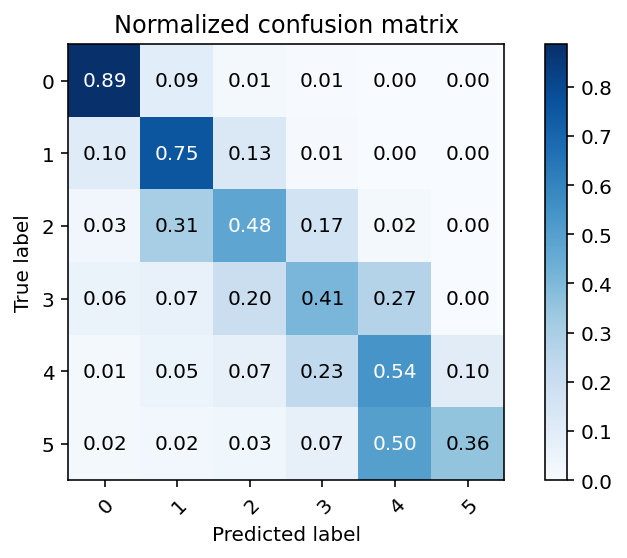

In [40]:
_ = plot_confusion_matrix(val_df.isup_grade, val_df.isup_pred, normalize=True)

In [41]:
logging.info(f"Models: {model_fnames}")

NameError: name 'model_fnames' is not defined

In [42]:
pred_kappa = cohen_kappa_score(val_df.isup_grade, val_df.isup_pred, weights="quadratic")

In [43]:
logging.info(f"Overall kapa: {pred_kappa}")

Overall kapa: 0.8697269781441653


In [44]:
karol_df = val_df[val_df.data_provider == "karolinska"].copy()
kapa_karol = cohen_kappa_score(karol_df.isup_grade, karol_df.isup_pred, weights="quadratic")
logging.info(f"Karolinska kapa: {kapa_karol}")

Karolinska kapa: 0.8578681825704073


In [45]:
radboud_df = val_df[val_df.data_provider == "radboud"].copy()
kapa_radboud = cohen_kappa_score(radboud_df.isup_grade, radboud_df.isup_pred, weights="quadratic")
logging.info(f"Radboud kapa: {kapa_radboud}")

Radboud kapa: 0.8489294056132233


#### Optimize Rounding

In [46]:
rnd_sample_ids = val_df.sample(frac=0.5).index

In [47]:
val_df["eval"] = 0
val_df.loc[rnd_sample_ids, "eval"] = 1

In [48]:
dev_preds = val_df.loc[val_df["eval"] == 0, "isup_raw_pred"].values
dev_targs = val_df.loc[val_df["eval"] == 0, "isup_grade"].values
eval_preds = val_df.loc[val_df["eval"] == 1, "isup_raw_pred"].values
eval_targs = val_df.loc[val_df["eval"] == 1, "isup_grade"].values

In [49]:
opt_r = OptimizedRounder()
opt_r.fit(dev_preds, dev_targs)

In [50]:
coefficients = opt_r.coefficients()
logging.info(f"Optimized coefs: {coefficients}")

Optimized coefs: [0.49674098 1.61728874 2.55145647 3.34682017 4.28873201]


In [51]:
eval_preds_round = opt_r.predict(val_df.isup_raw_pred, coefficients)

In [52]:
round_opt_kapa = cohen_kappa_score(val_df.isup_grade, eval_preds_round, weights="quadratic")

In [53]:
logging.info(f"Optimized round kapa: {round_opt_kapa}")

Optimized round kapa: 0.8743616587699317


#### Check results with Hard Class Permutation

In [43]:
hard_cls_values = val_df.loc[val_df.isup_pred.isin([2,3,4]), "isup_pred"].copy().values

In [44]:
hard_cls_values[:5]

array([4, 3, 4, 2, 3])

In [45]:
np.random.shuffle(hard_cls_values)

In [46]:
hard_cls_values[:5]

array([3, 4, 3, 4, 2])

In [47]:
val_df.loc[val_df.isup_pred.isin([2,3,4]), "isup_pred"] = hard_cls_values

Normalized confusion matrix
[[0.94382022 0.03792135 0.00702247 0.00421348 0.00280899 0.00421348]
 [0.0830721  0.79937304 0.03605016 0.04702194 0.03291536 0.0015674 ]
 [0.04126984 0.27936508 0.25396825 0.22222222 0.18412698 0.01904762]
 [0.09310345 0.05862069 0.26896552 0.23793103 0.24482759 0.09655172]
 [0.0652921  0.03780069 0.26460481 0.25429553 0.2371134  0.14089347]
 [0.05818182 0.01454545 0.11636364 0.10545455 0.14909091 0.55636364]]


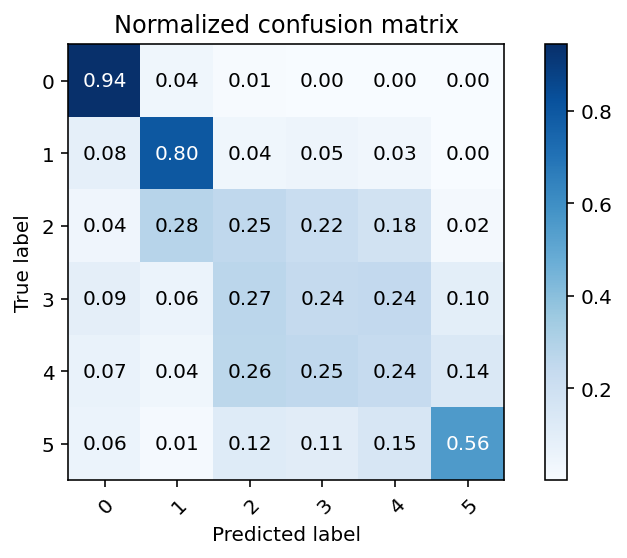

In [48]:
_ = plot_confusion_matrix(val_df.isup_grade, val_df.isup_pred, normalize=True)

In [49]:
permute_kapa = cohen_kappa_score(val_df.isup_grade, val_df.isup_pred, weights="quadratic")
permute_kapa

0.7659439769237075

In [50]:
print(f"Permutation importance: {1 - (permute_kapa/pred_kappa)}")

Permutation importance: 0.07017338008015972


In [34]:
# LB
print(f"LB Permutation importance: {1 - (0.80/0.84)}")

LB Permutation importance: 0.04761904761904756
